In [9]:
import sys
sys.path.append('../')

import copy
import glob
from collections import defaultdict
from typing import *

import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm
from sklearn.preprocessing import StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Sampler, SubsetRandomSampler

from torchmetrics import R2Score as torchR2
from sklearn.metrics import r2_score, mean_squared_error

import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = List[Union[np.ndarray, None]]
Targets = List[Union[np.ndarray, None]]
Additional_Features = List[np.ndarray]


class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        targets (List of Numpy arrays): List of node label (target) tensors.
        **kwargs (optional List of Numpy arrays): List of additional attributes.
    """

    def __init__(
            self,
            edge_index: Edge_Index,
            edge_weight: Edge_Weight,
            targets: Targets,
            **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.targets)

    def _check_temporal_consistency(self):
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = pyg.data.Data(edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.targets):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

    def __len__(self):
        return len(self.targets)


In [11]:
# StandartScaler that can handle >2dim data
class Scaler(StandardScaler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def fit(self, X, **kwargs):
        shape = X.shape
        X = X.reshape(shape[0], -1)
        super().fit(X, **kwargs)
    def transform(self, X, **kwargs):
        shape = X.shape
        X = X.reshape(shape[0], -1)
        out = super().transform(X, **kwargs).reshape(*shape)
        return out
    def inverse_transform(self, X, **kwargs):
        shape = X.shape
        X = X.reshape(shape[0], -1)
        out = super().inverse_transform(X, **kwargs).reshape(*shape)
        return out

In [12]:
np.random.seed(17)
plt.figure(figsize=(20, 12))
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

SEQ_LEN = 4
TRAVEL_DIST_FILTER = 20
target_scaler = None

<Figure size 2000x1200 with 0 Axes>

In [13]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')
nx.set_node_attributes(G, {n: {'id': n} for n in G.nodes()})
edges = []
spl = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

for node in G.nodes():
    neibs = list(nx.ego_graph(G, radius=TRAVEL_DIST_FILTER, n=node, distance='weight', center=False).nodes)
    edges.extend([(node, x, {'weight': spl[node][x]}) for x in neibs])

G.remove_edges_from(list(G.edges))
G.add_edges_from(edges)

In [14]:
# Pytorch geometric Data object containing node features
pyg_data = from_networkx(G, group_node_attrs=['embedding'], group_edge_attrs=['weight'])
obs_nodes: List
pyg_data

Data(edge_index=[2, 25440], id=[1128], x=[1128, 32], edge_attr=[25440, 1])

In [15]:
edge_index = pyg_data.edge_index
edge_index

tensor([[   0,    0,    0,  ..., 1127, 1127, 1127],
        [   3,    2,  190,  ...,  246,  851,  852]])

In [16]:
edges = []
spl = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

for node in G.nodes():
    neib = list(nx.ego_graph(G, radius=TRAVEL_DIST_FILTER, n=node, distance='weight', center=False).nodes)
    edges.extend([(node, x, spl[node][x]) for x in neib])
print(len(edges))

25440


In [17]:
class CzechRoadsDatasetLoader:
    def __init__(self, targets : np.array, edge_index=None, edge_attr=None, **features):
        super().__init__()
        self.X = np.copy(targets)

        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.features = features

    def _generate_task(self, window_len : int = 1):
        indices = [
            (i, i + window_len)
            for i in range(self.X.shape[0] - window_len + 1)
        ]

        # Generate observations
        targets = []
        features = defaultdict(list)

        for i, j in indices:
            targets.append(self.X[i : j])

            for k, v in self.features.items():
                features[k].append(v[i: j])

        self.features = features
        self.targets = targets
        self.features = features

    def get_dataset(
            self, window_len : int = SEQ_LEN+1) -> StaticGraphTemporalSignal:
        self._generate_task(window_len)
        dataset = StaticGraphTemporalSignal(
            self.edge_index, self.edge_attr, targets=self.targets, **self.features
        )
        return dataset

In [18]:
def preprocess_target_df(df) -> pd.DataFrame:
    """If more than 25% of time series for a station is missed -> drop the station
    also drops the last 7% of the observations due it feels like an anomaly behavior"""
    df = df.loc[:int(len(df) * 0.93)]
    df = df.loc[:, df.isna().sum() / len(df) < 0.25]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

def preprocess_feature_df(df, obs_nodes) -> pd.DataFrame:
    """Drops the last 7% of the observations due it feels like an anomaly behavior"""
    df = df.loc[:int(len(df) * 0.93)]
    df = df[obs_nodes]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

def make_datetime_features(time_series):
    """The idea here is to generate harmonic features of the time and date
    (projecting the time onto a circle and using two coordinates).

    The period here follows from the fact we are using 15 min interval between 2 consequential snapshots.
    The total number of obtained features is 4.
    """
    time_series = pd.to_datetime(time_series)
    period = 24 * 4
    weekday = time_series.dt.weekday.values
    # is_weekend = (time_series.dt.weekday > 4).values[:, None]
    dt = weekday * 2 * np.pi / 7.0
    dt_harmonic = np.stack([np.cos(dt), np.sin(dt)], axis=-1)
    tm = (time_series.dt.hour.values * 4 + time_series.dt.minute.values // 15)
    tm = tm * 2 * np.pi / period
    tm_harmonic = np.stack([np.cos(tm), np.sin(tm)], axis=-1)

    return np.hstack([dt_harmonic, tm_harmonic])


class HistoricalAverage:
    def __init__(self):
        self.stats = None

    @staticmethod
    def make_hash(time_series):
        tm = (time_series.dt.hour.values * 4 + time_series.dt.minute.values // 15)
        dt = time_series.dt.weekday.values
        time_series_hash = dt * 24 * 4 + tm
        return time_series_hash

    def fit(self, targets, time_series):
        time_series = pd.to_datetime(time_series)
        time_series_hash = self.make_hash(time_series)

        tmp_dict = defaultdict(list)
        for hash_, snapshot in zip(time_series_hash, targets):
            tmp_dict[hash_].append(snapshot)

        self.stats = dict()
        for hash_, snapshots in tmp_dict.items():
            stacked = np.vstack(snapshots)
            self.stats[hash_] = stacked.mean(axis=0)

    def get(self, time_series):
        time_series = pd.to_datetime(time_series)
        time_series_hash = self.make_hash(time_series)

        res = np.stack([self.stats[h] for h in time_series_hash])
        return res

def make_datasets(target_df,
                  features : Optional[MutableMapping[str, pd.DataFrame]] = None,
                  snapshot_features: Optional[MutableMapping[str, pd.Series]] = None) \
        -> Tuple[StaticGraphTemporalSignal, StaticGraphTemporalSignal, StaticGraphTemporalSignal]:
    target_df = preprocess_target_df(target_df)
    global obs_nodes
    obs_nodes = target_df.columns.to_list()
    # removing dropped nodes from the initial graph
    global pyg_data
    pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in obs_nodes]))
    pyg_data.id = obs_nodes

    # to np
    targets = target_df.to_numpy()

    # makes train-val-test slices
    train_slice = slice(int(len(target_df) * 0.6))
    val_slice = slice(int(len(target_df) * 0.6), int(len(target_df) * 0.8))
    test_slice = slice(int(len(target_df) * 0.8), len(target_df))

    # fit scalers
    global target_scaler
    target_scaler = Scaler()
    target_scaler.fit(targets[train_slice])

    # normalize
    targets = target_scaler.transform(targets)

    all_features = dict()

    # features for every node and timestamp
    if features is not None:
        for k, df in features.items():
            features[k] = preprocess_feature_df(df, obs_nodes)

        # to np
        features = {k: v.to_numpy() for k, v in features.items()}

        # fit scalers
        feature_scalers = [Scaler() for x in range(len(features))]
        for arr, scaler in zip(features.values(), feature_scalers):
            scaler.fit(arr[train_slice])

        for (k, arr), scaler in zip(features.items(), feature_scalers):
            features[k] = scaler.transform(arr)

        all_features.update(features)

    # features only for every timestamp like datetime
    if snapshot_features is not None:
        if 'time_feats' in snapshot_features:
            time_info = snapshot_features['time_feats']
            snapshot_features['time_feats'] = make_datetime_features(snapshot_features['time_feats'])

            # using the whole dataset for historical average
            stats_maker = HistoricalAverage()
            # stats_maker.fit(targets, time_info)
            stats_maker.fit(targets[train_slice], time_info[train_slice])
            hist_average = stats_maker.get(time_info)
            all_features.update({'hist_average_y': hist_average})
        all_features.update(snapshot_features)

    train_loader = CzechRoadsDatasetLoader(targets=targets[train_slice],
                            edge_index=pyg_data.edge_index,
                            edge_attr=pyg_data.edge_attr,
                            **{k : v[train_slice] for k, v in all_features.items()}
                            )

    val_loader = CzechRoadsDatasetLoader(targets=targets[val_slice],
                                           edge_index=pyg_data.edge_index,
                                           edge_attr=pyg_data.edge_attr,
                                           **{k : v[val_slice] for k, v in all_features.items()}
                                           )

    test_loader = CzechRoadsDatasetLoader(targets=targets[test_slice],
                                         edge_index=pyg_data.edge_index,
                                         edge_attr=pyg_data.edge_attr,
                                         **{k : v[test_slice] for k, v in all_features.items()}
                                         )

    return train_loader.get_dataset(), val_loader.get_dataset(), test_loader.get_dataset()

In [19]:
targets = pd.read_csv('data/intensity.csv')
avg_speed = pd.read_csv('data/avg_speed.csv')
features = {'avg_speed': avg_speed}
time_info = targets['datetime']
snapshot_features = {'time_feats': time_info}
targets.drop(columns=['datetime'], inplace=True)

for f in features.values():
    assert time_info.equals(f['datetime'])
    f.drop(columns=['datetime'], inplace=True)
    assert f.shape == targets.shape

train_ds, val_ds, test_ds = make_datasets(targets, features, snapshot_features)

In [20]:
# seq_len = 13 -> the first 12 stamps for observations from (T - 12, T - 11, ... T), the last one - for T + 1.
train_ds[0]

Data(edge_index=[2, 21980], edge_attr=[21980, 1], y=[5, 1028], avg_speed=[5, 1028], hist_average_y=[5, 1028], time_feats=[5, 4])

In [21]:
from statistics import mean

def show_train_plot(train_losses: Sequence[int], val_losses: Sequence[int], 
  val_scores: Sequence[int], train_scores: Sequence[int]=None):
    _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
    sns.lineplot(ax=axes[0], x=range(len(train_losses)), y=train_losses, label='Train', color='blue')
    sns.lineplot(ax=axes[0], x=range(len(val_losses)), y=val_losses, label='Val', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    sns.lineplot(ax=axes[1], x=range(len(val_scores)), y=val_scores, label='Val', color='red')
    if train_scores is not None:
        sns.lineplot(ax=axes[1], x=range(len(train_scores)), y=train_scores, label='Train', color='blue')
    
    # axes[1].set_ylim(0.5, 1)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].legend()

    plt.show()


def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for snapshot in loader:
            snapshot = snapshot.to(device)
            out = model(snapshot)

            outs.append(out)
            ys.append(snapshot.y[-1])

            loss = loss_fn(out, snapshot.y[-1])
            losses.append(loss.item())
    
    ys = torch.vstack(ys).detach().cpu().numpy()
    outs = torch.vstack(outs).detach().cpu().numpy()

    global target_scaler
    score = score_fn(target_scaler.inverse_transform(outs).reshape(-1),
                     target_scaler.inverse_transform(ys).reshape(-1)).item()
    return mean(losses), score

def train(model, train_loader, val_loader, loss_fn, score_fn, optimizer, device=device,
          scheduler=None, num_epochs=10, increasing_score=True, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    if increasing_score:
        best_val_score = -torch.inf
    else:
        best_val_score = torch.inf
    best_model = None

    temp_loss = 0

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []
        optimizer.zero_grad()
        for i, snapshot in enumerate(train_loader):
            snapshot = snapshot.to(device)
            out = model(snapshot)
            loss = loss_fn(out, snapshot.y[-1])
            losses.append(loss.item())
            temp_loss = temp_loss + loss
            if (i + 1) % 8 == 0 or i + 1 == len(train_loader):
                temp_loss /= 8
                temp_loss.backward()
                temp_loss = 0
                optimizer.step()
                optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if (increasing_score and val_score > best_val_score) or (not increasing_score and val_score < best_val_score):
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            show_train_plot(train_losses, val_losses, val_scores)

        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [35]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

def scaled_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred)) / np.std(y_pred)

In [23]:
loss_fn = nn.MSELoss().to(device)
# loss_fn = nn.L1Loss().to(device)

score_fn = scaled_rmse
# score_fn = r2_score
pyg_data = pyg_data.to(device)

INCREASING_SCORE = False

results = {}

def run(model, results, num_epochs=20, lr=1e-3, *args, **kwargs):
    if num_epochs > 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.8)

        model = train(model, train_ds, val_ds,
            loss_fn, score_fn, optimizer, increasing_score=INCREASING_SCORE, num_epochs=num_epochs, *args, **kwargs)

    test_loss, test_score = test(model, test_ds, loss_fn, score_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

In [24]:
import random

def evaluate_plot(model, loader, nodes_ids=obs_nodes, nodes_num=5):
    outs, ys = [], []
    fig, axes = plt.subplots(nodes_num, figsize=(20, nodes_num * 6))

    with torch.no_grad():
        for snapshot in loader:
            snapshot = snapshot.to(device)
            out = model(snapshot)

            outs.append(out)
            ys.append(snapshot.y[-1])
        
        # ys = scaler.inverse_transform(torch.vstack(ys)).detach().cpu().numpy()
        # outs = scaler.inverse_transform(torch.vstack(outs)).detach().cpu().numpy()
        ys = torch.vstack(ys).detach().cpu().numpy()
        outs = torch.vstack(outs).detach().cpu().numpy()
        global target_scaler
        ys = target_scaler.inverse_transform(ys)
        outs = target_scaler.inverse_transform(outs)

        # print(outs.std())

        for idx, node in enumerate(random.choices(range(len(nodes_ids)), k=nodes_num)):
            axes[idx].set_title(nodes_ids[node])
            # axes[idx].plot(ds.y[test_loader.sampler.indices, node], label='actual', c='r')
            axes[idx].plot(ys[:, node], label='actual', c='r')
            axes[idx].plot(outs[:, node], label='pred', c='b')
            axes[idx].legend()
        plt.show()

<h1>Input specs</h1>

window = 13 -> the first 12 stamps - for observations from (T - 12, T - 11, ... T), the last one - for T + 1.<br>
<b>Input structure:</b>
pyg.data.Data(edge_index=[2, edge_num], edge_attr=[edge_num, attr_num (now 1 - only dist)],
 y=[window, nodes_num], avg_speed=[windows, nodes_num],
 hist_average_y=[window, nodes_num], time_feats=[window, time_feats_dim])

Example:
Data(edge_index=[2, 2062], edge_attr=[2062, 1], y=[13, 1028], avg_speed=[13, 1028], hist_average_y=[13, 1028], time_feats=[13, 4])


<h2>Historical Average</h2>

Type: PriorPredictionModel, Test loss: 0.13, Test score: 0.2002


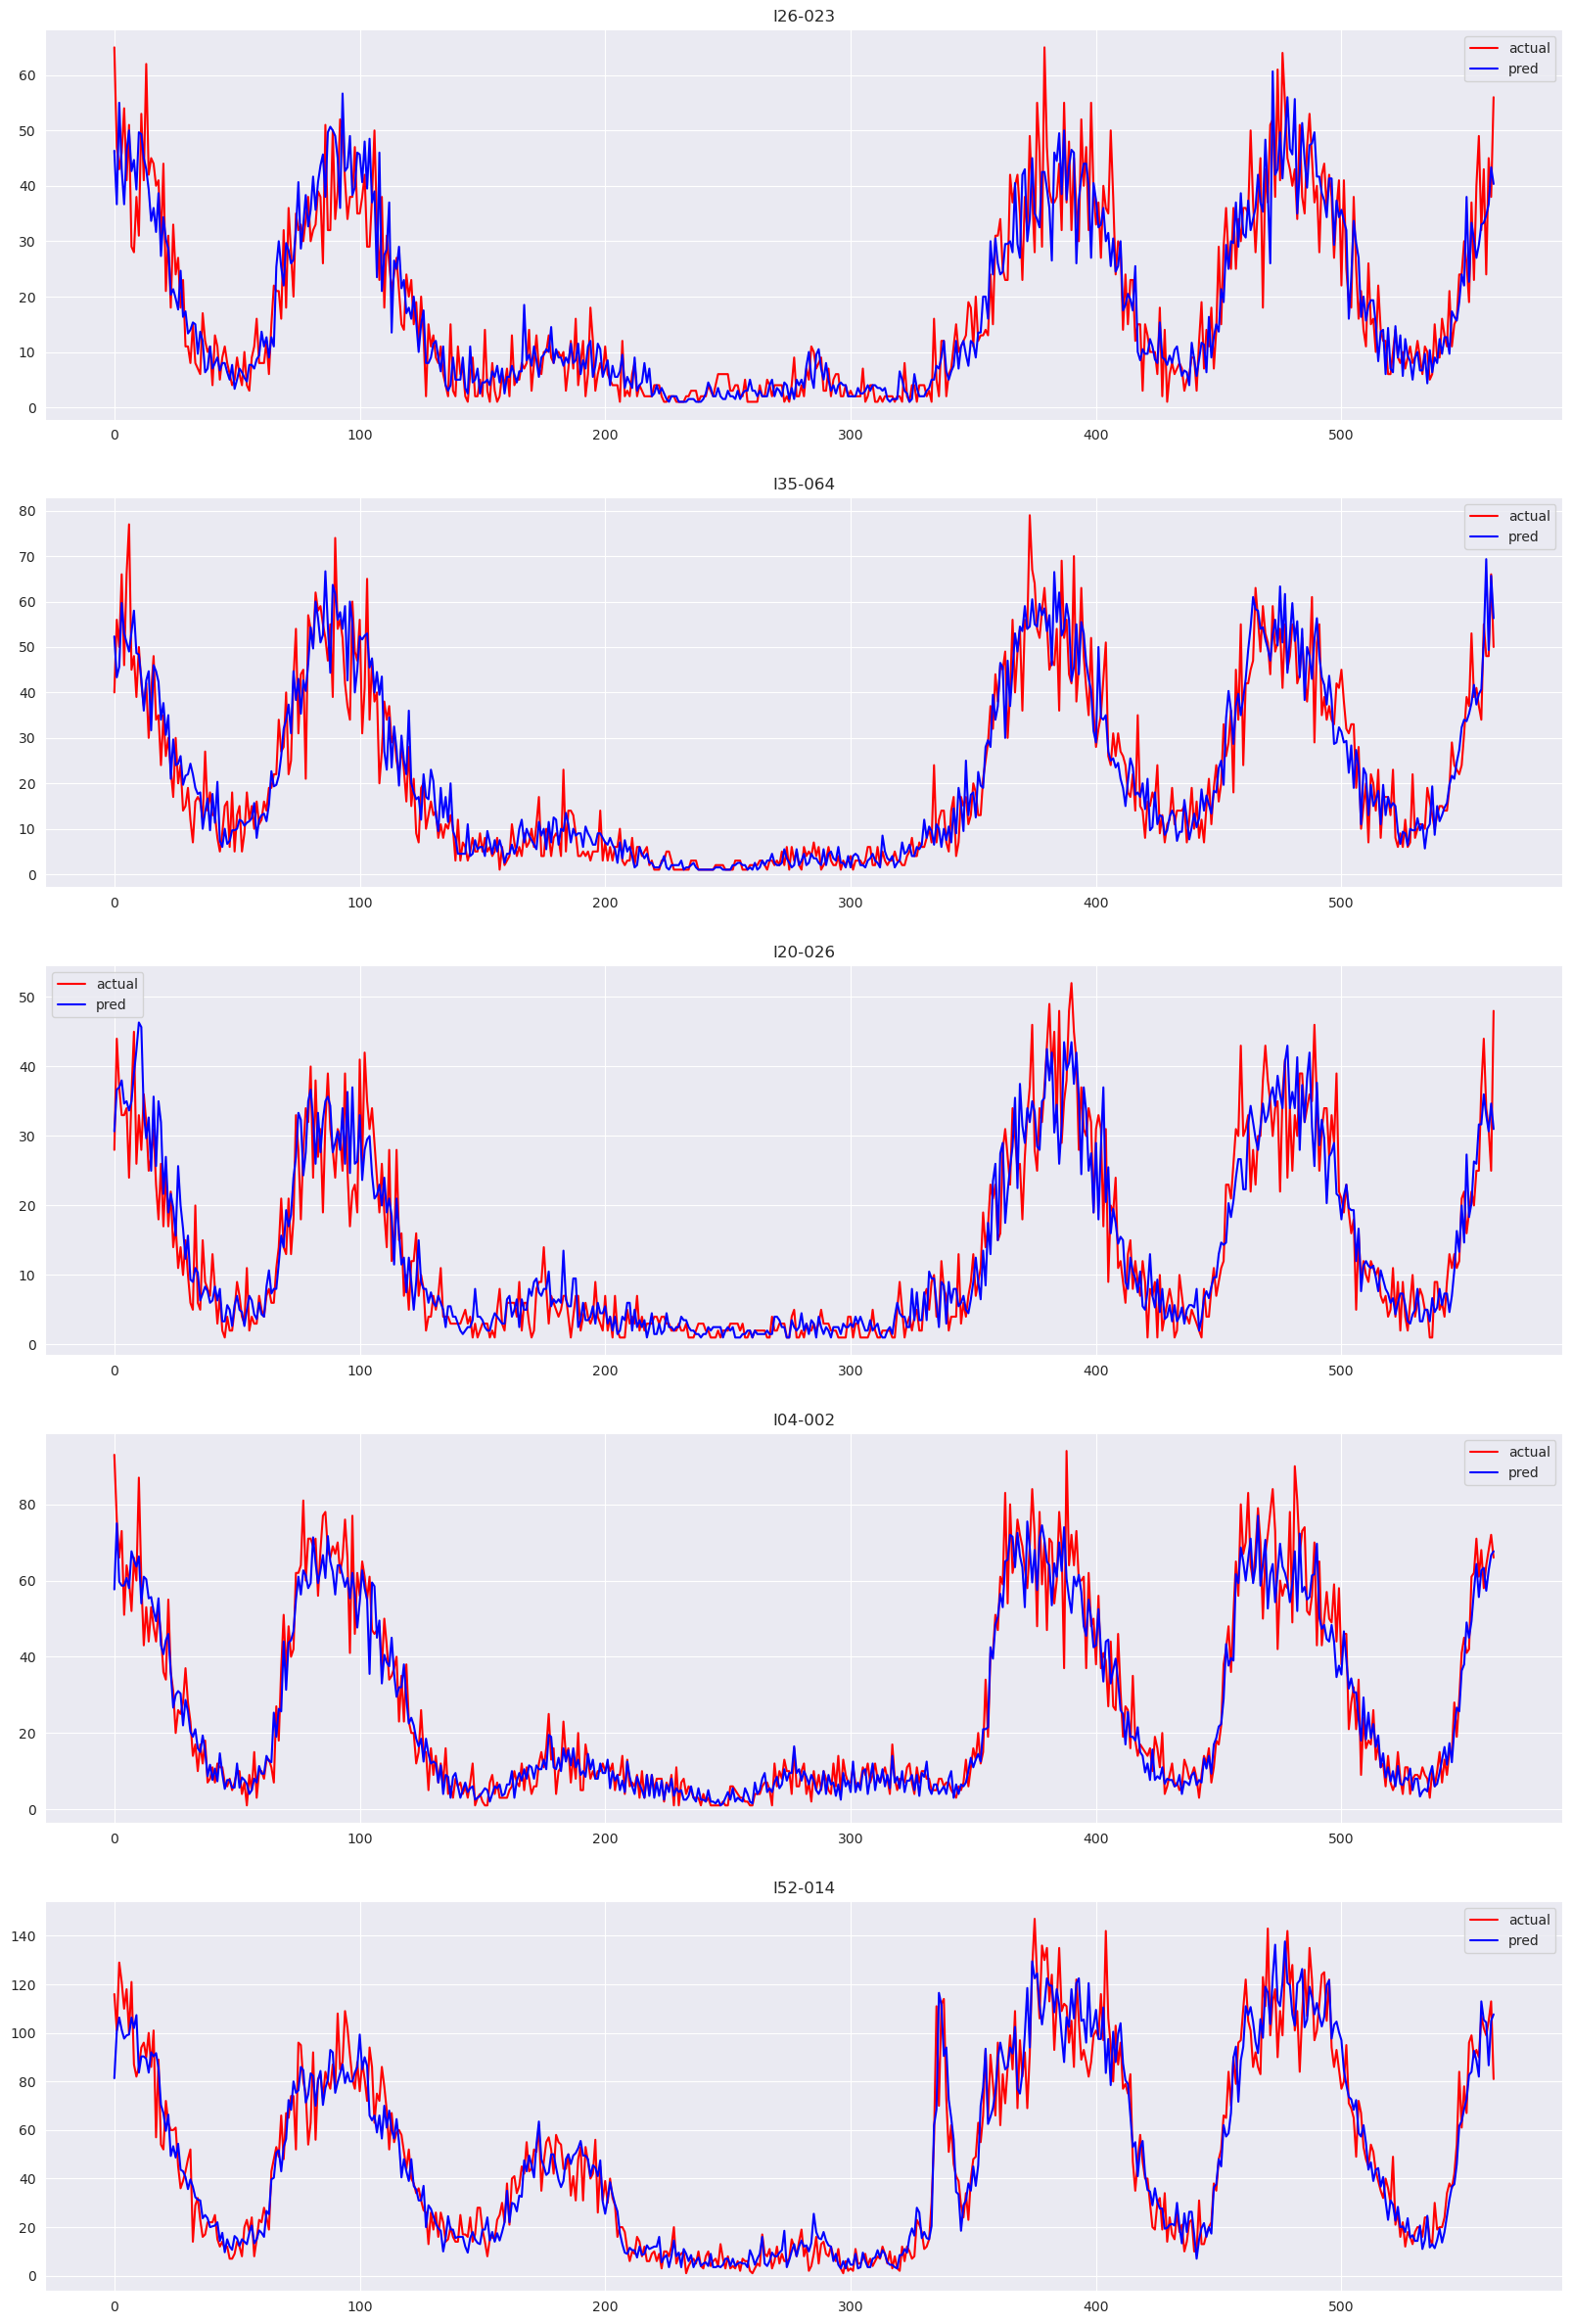

In [25]:
class PriorPredictionModel(nn.Module):
    def __init__(self, seq_len, in_channels, out_channels=1):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, X):
        return X.hist_average_y[-1]

model = PriorPredictionModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, num_epochs=0, plot=True, plot_update_freq=5)
evaluate_plot(model, test_ds)

<h2>Linear Model</h2>

Running LinR on every node, input for the regression - seq_len * in_features 

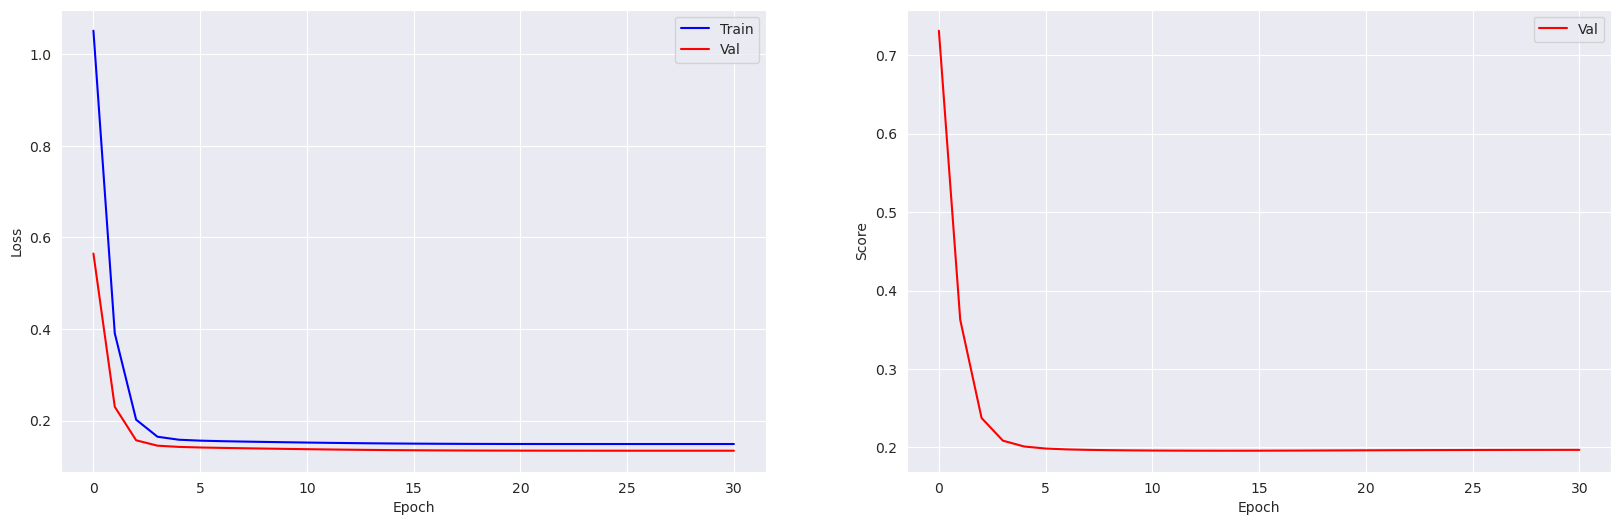

Type: LinearModel, Test loss: 0.13, Test score: 0.2064


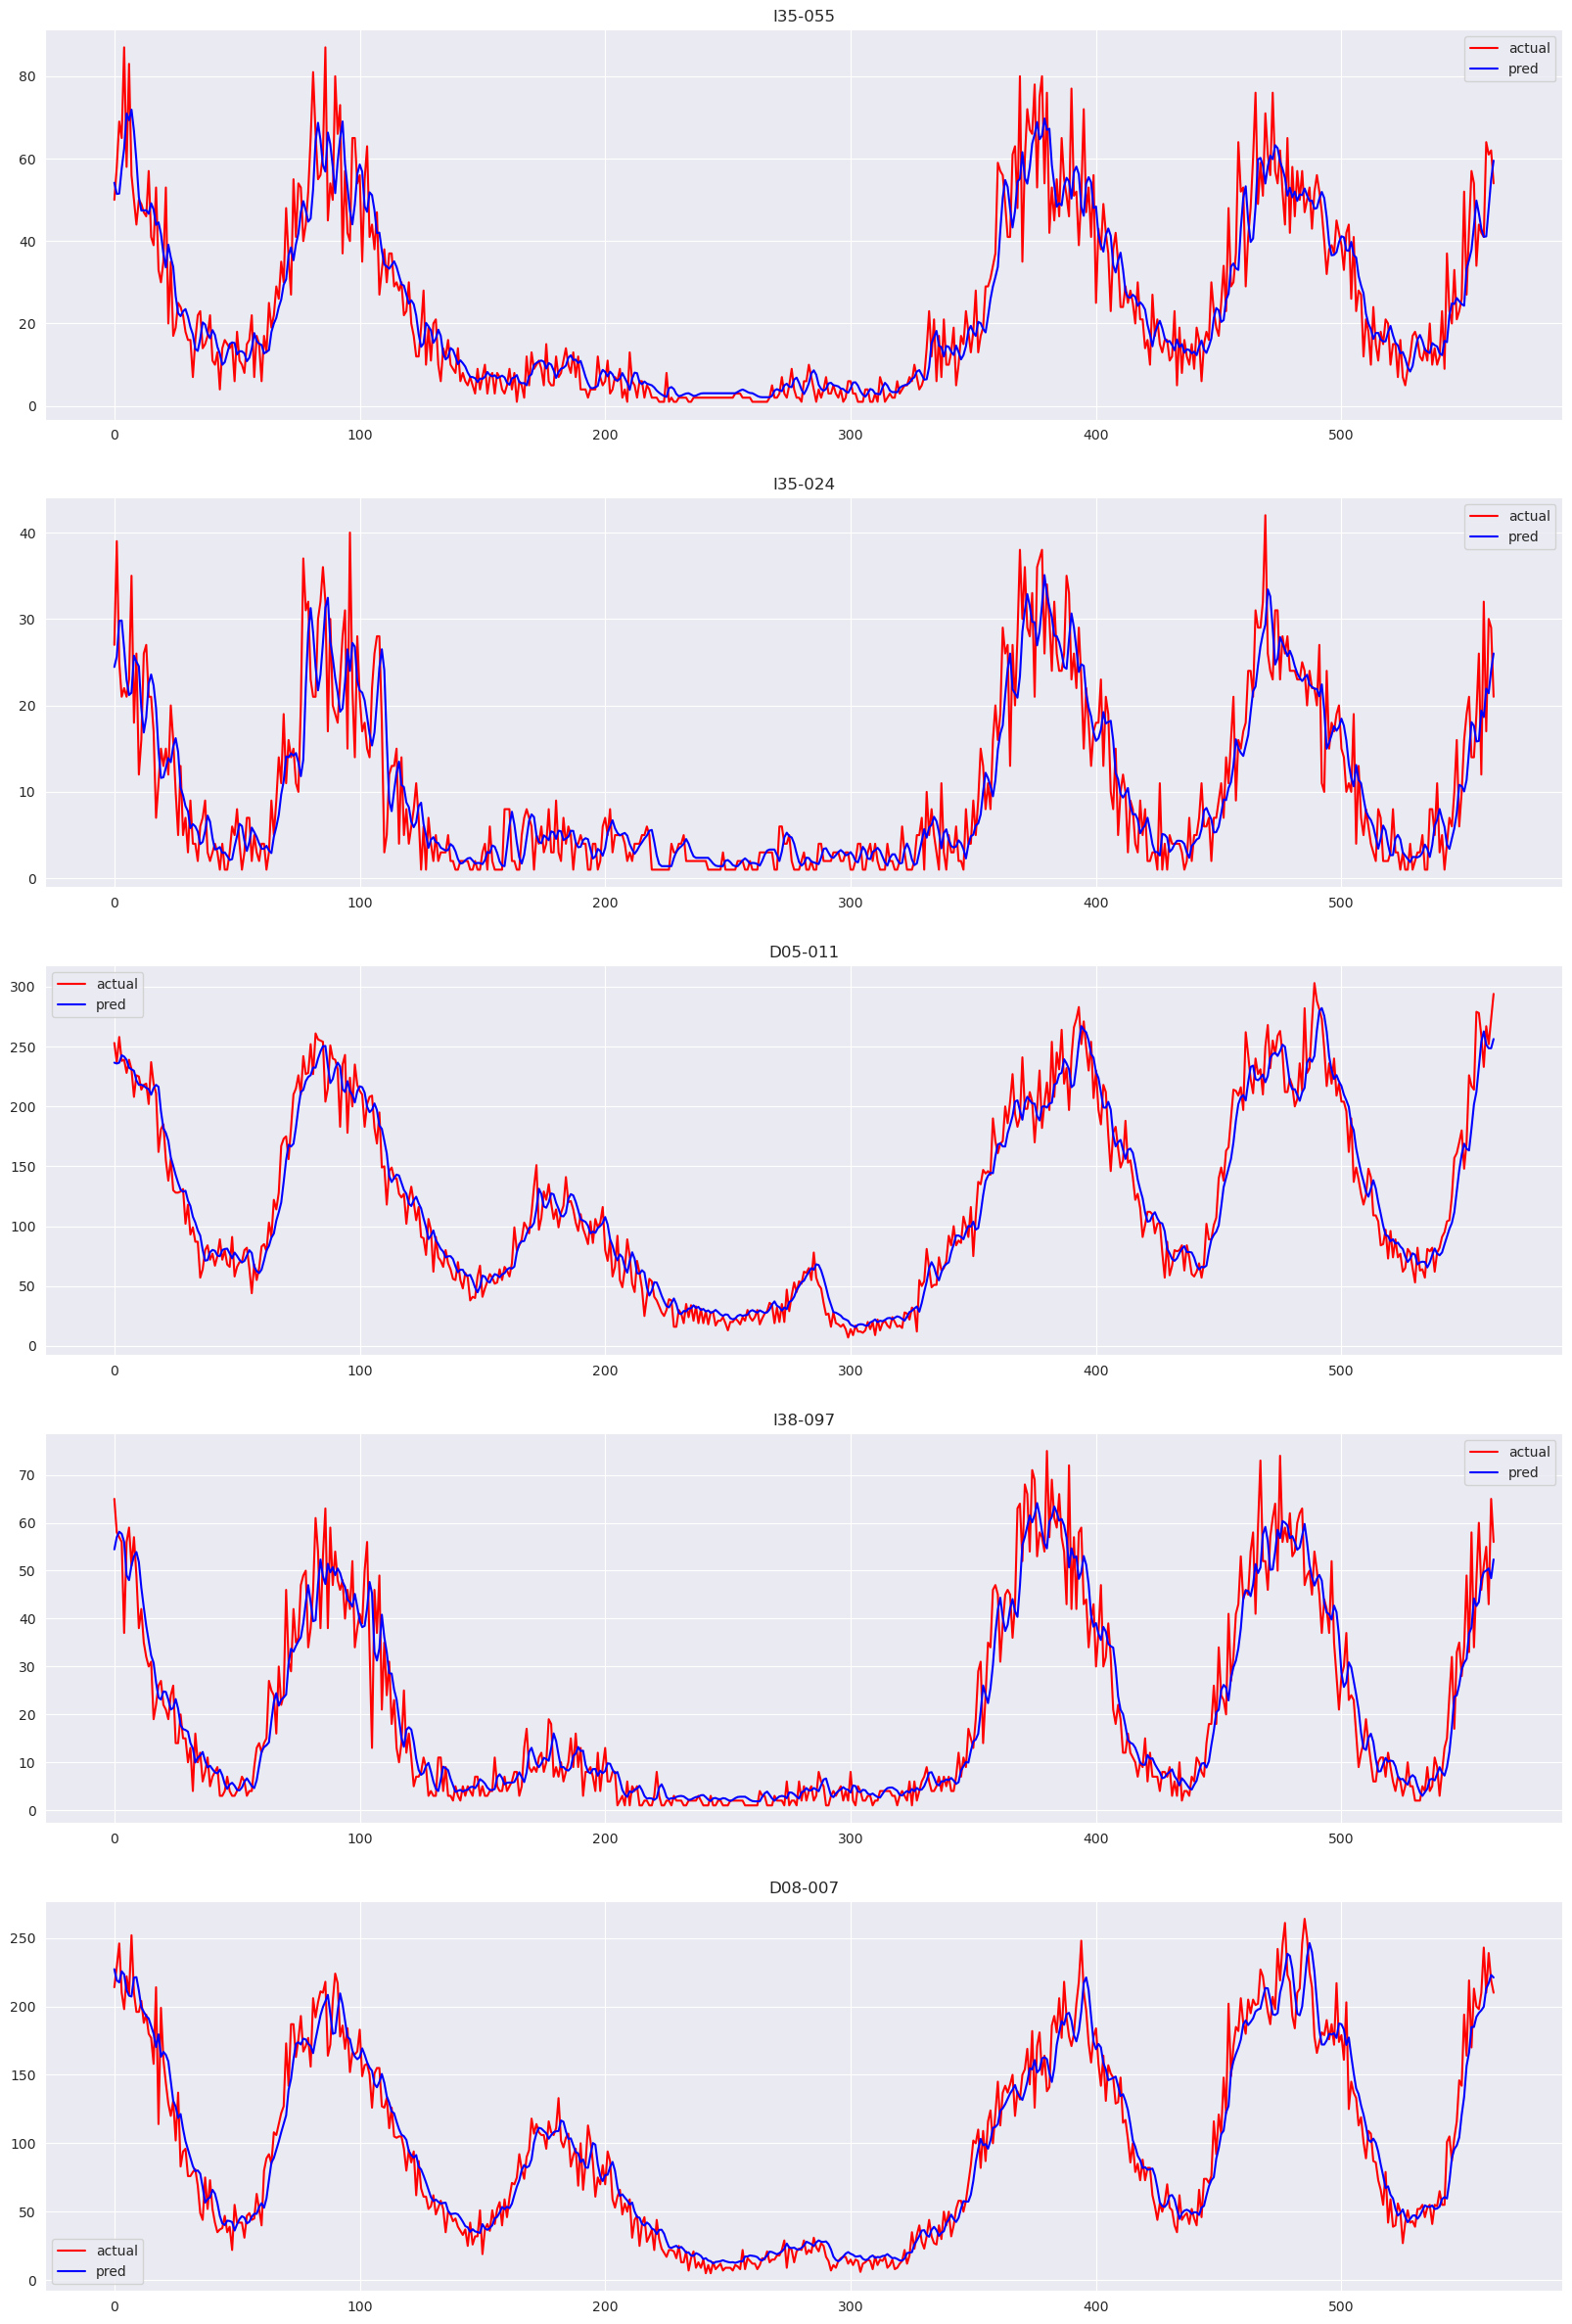

In [75]:
class LinearModel(nn.Module):
    def __init__(self, seq_len, in_channels, out_channels=1):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = nn.Linear(self.window * self.in_channels, self.out_channels, bias=True)

    def forward(self, snapshot):
        x = snapshot.y[:-1]
        x = x.transpose(0, 1)
        nodes_num = len(x)
        x = x.reshape(nodes_num, -1)

        out = self.lin(x).squeeze(-1)
        return out

model = LinearModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=1e-3, num_epochs=30, plot=True, plot_update_freq=2)
evaluate_plot(model, test_ds)

<h2>LSTM</h2>

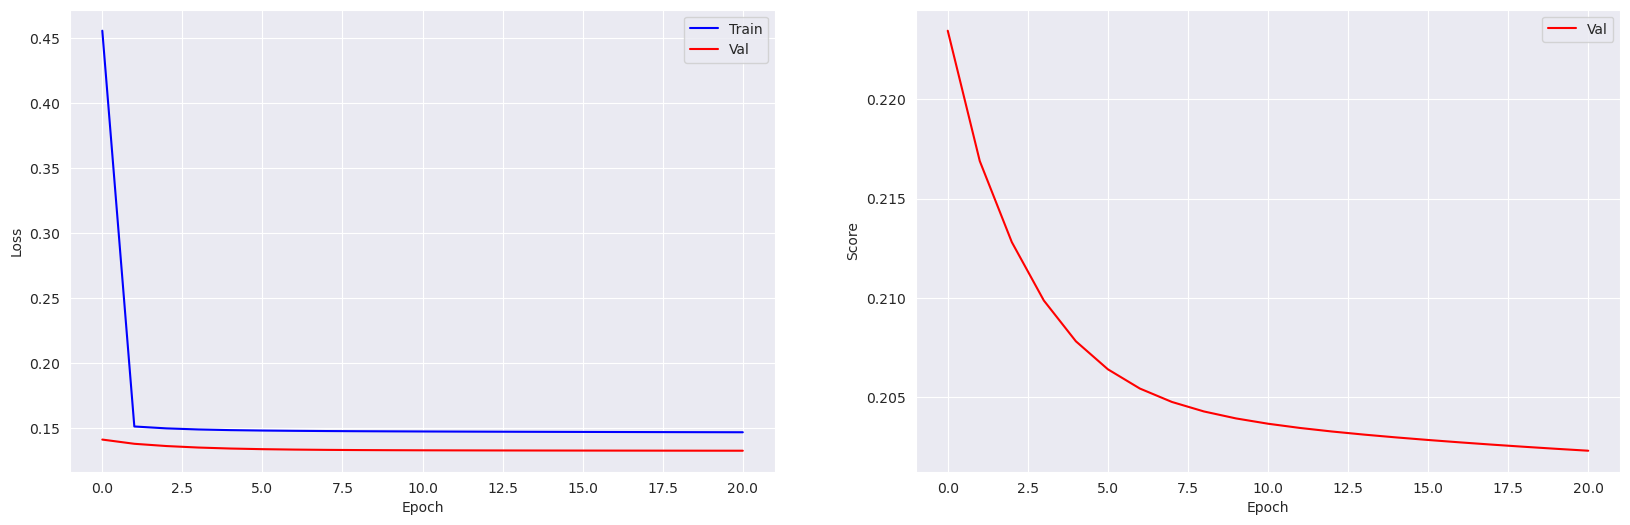

/home/eldervald/miniconda3/envs/graph/lib/python3.7/site-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: LSTMModel, Test loss: 0.13, Test score: 0.2129


/home/eldervald/miniconda3/envs/graph/lib/python3.7/site-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


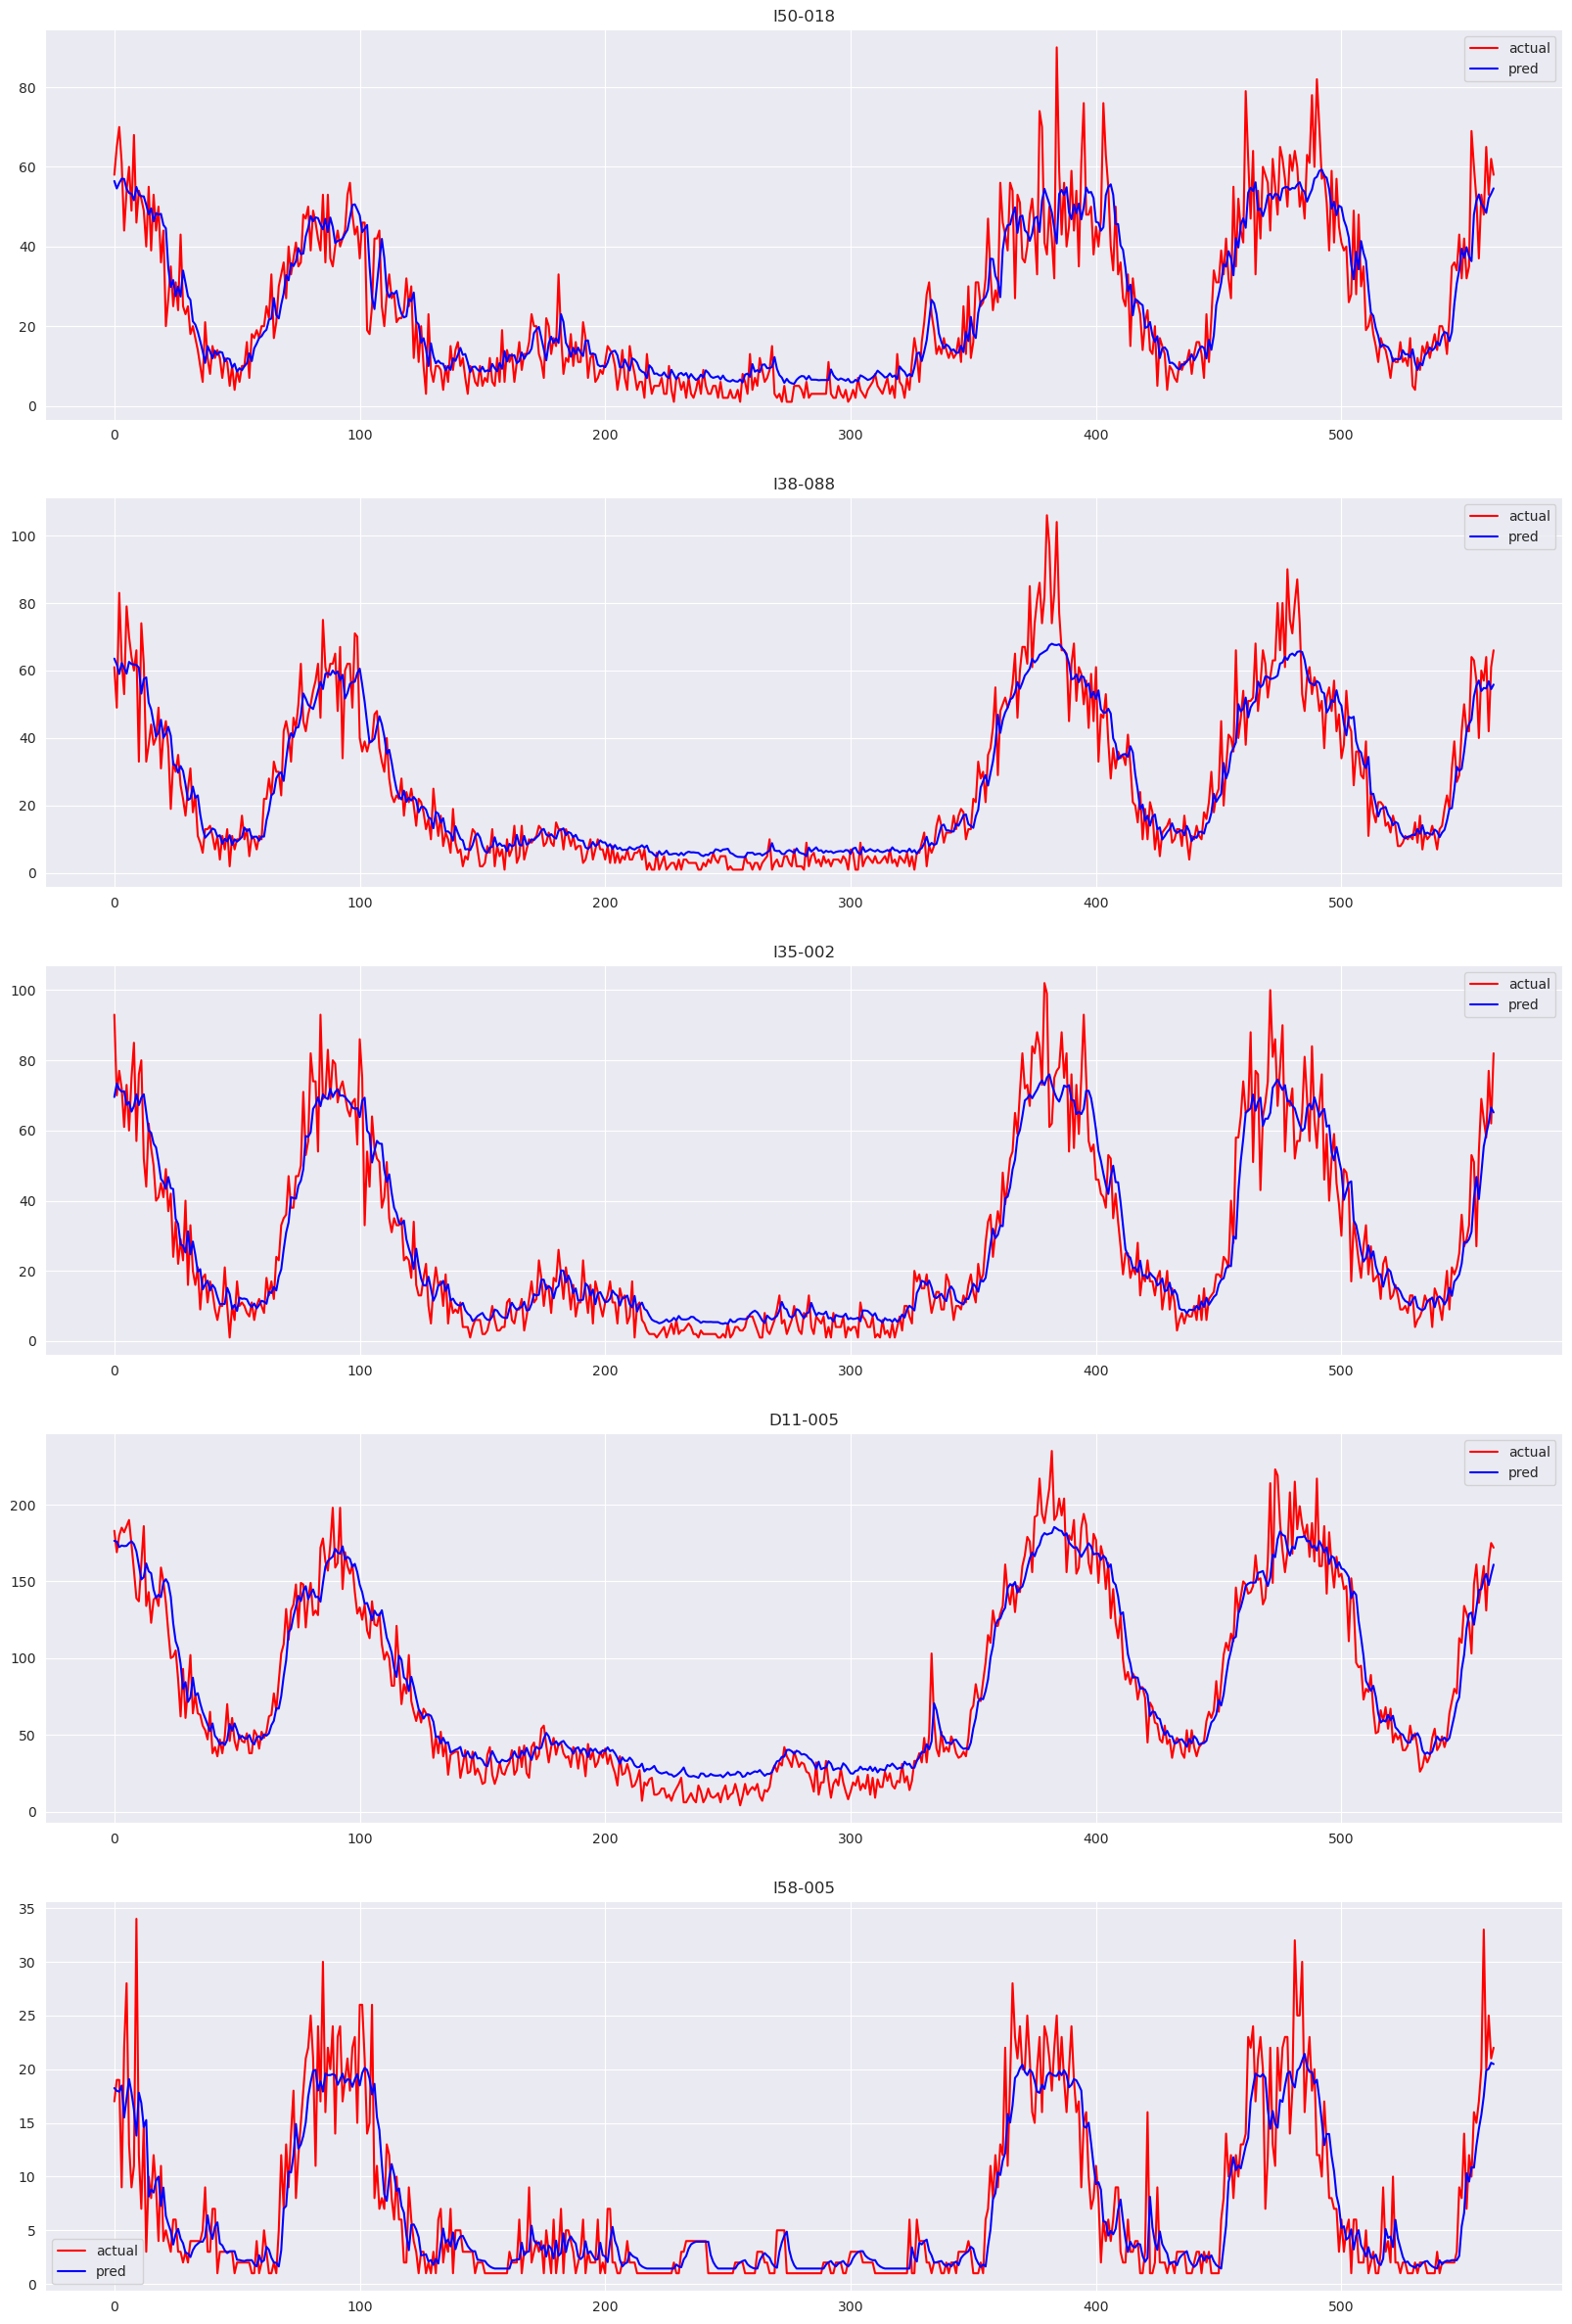

In [76]:
class LSTMModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, hidden_size=32, num_layers=2, bidirectional=True):
        super().__init__()
        self.in_channels = in_channels
        self.window = seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.lin = nn.Linear(self.hidden_size * (2 if self.bidirectional else 1), 1)
    
    def forward(self, snapshot):
        x = snapshot.y[:-1]
        x = x.transpose(0, 1)
        x = x.unsqueeze(-1)

        out, (hn, cn) = self.rnn(x)
        out = out[:, -1, :]
        out = self.lin(out).squeeze(-1)
        return out

model = LSTMModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=5e-4, num_epochs=20, plot=True, plot_update_freq=2)
evaluate_plot(model, test_ds)

<h2>VNN</h2>

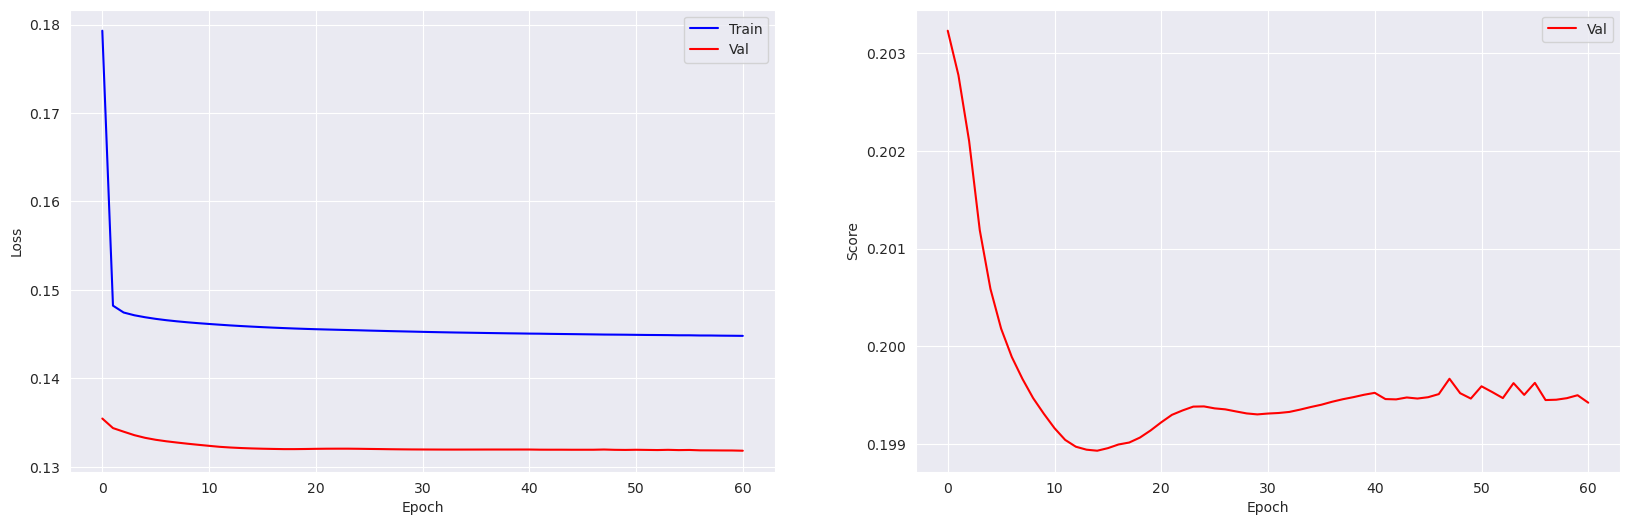

Type: VNNModel, Test loss: 0.13, Test score: 0.2092


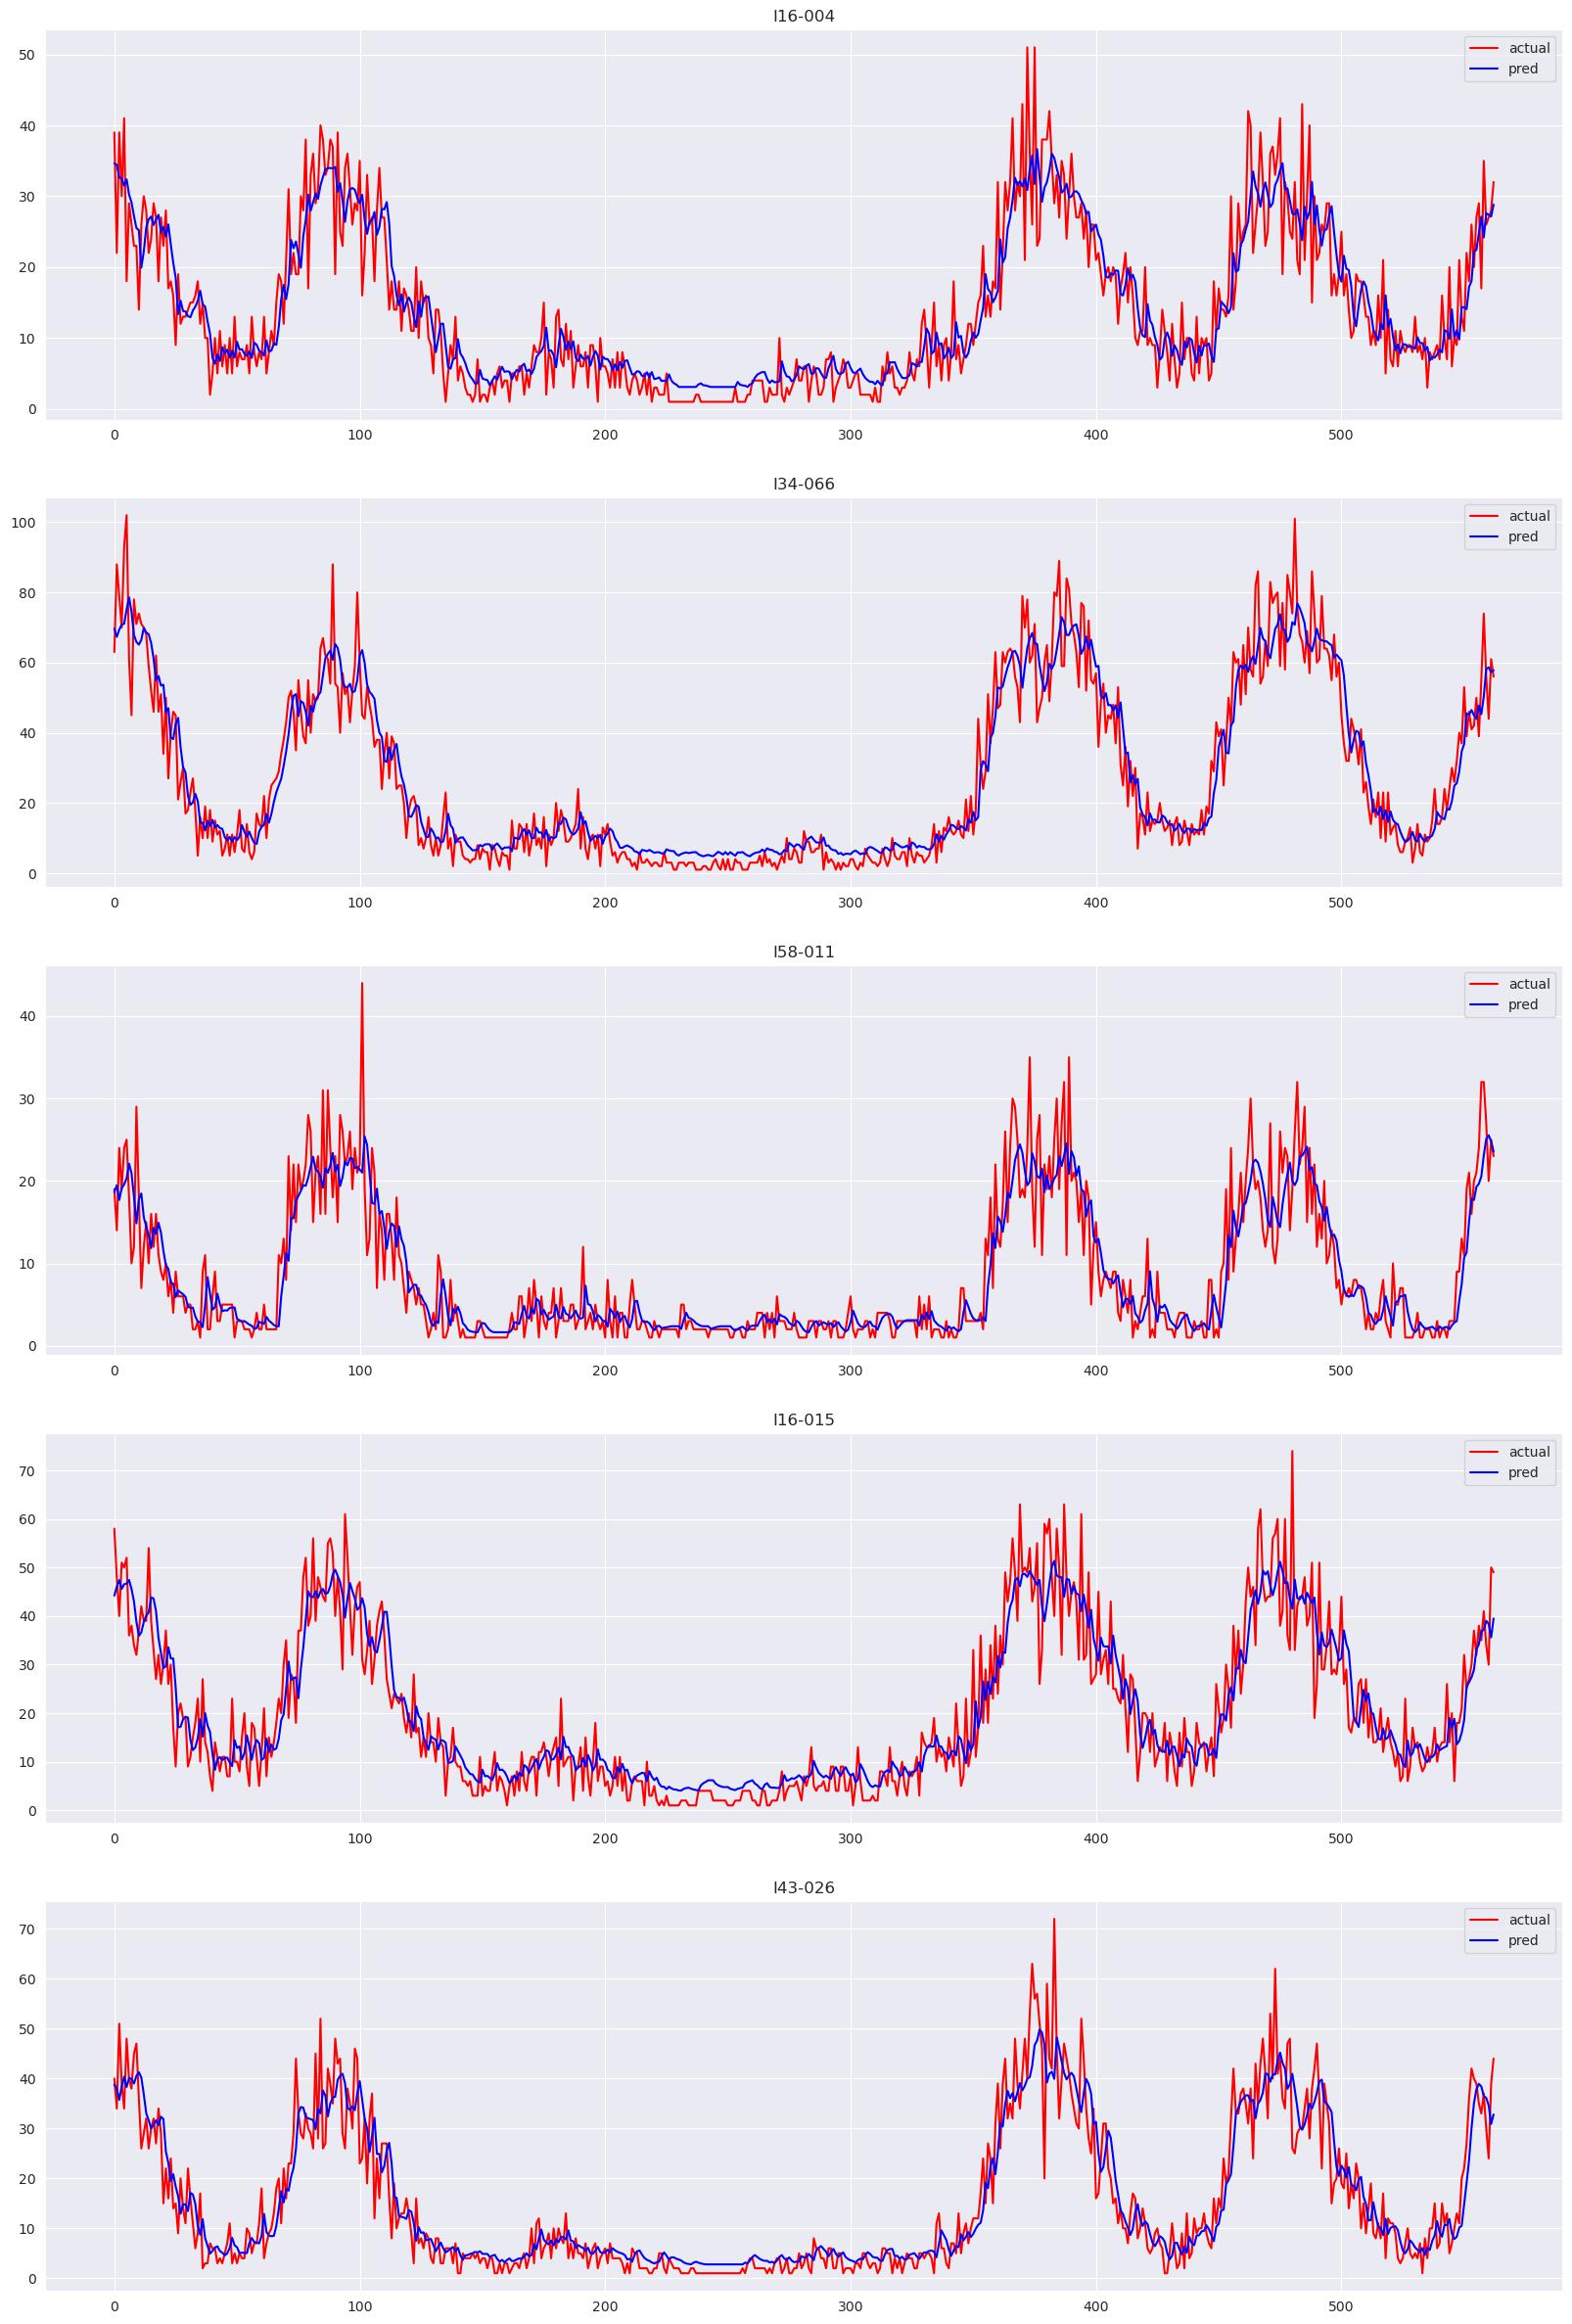

In [77]:
class VNNModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, hidden_dim = 64):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        
        self.nn = nn.Sequential(
            nn.Linear(in_channels * self.window, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )
    
    def forward(self, snapshot : pyg.data.Data):
        x = snapshot.y[:-1]
        x = x.transpose(0, 1)
        nodes_num = len(x)
        x = x.reshape(nodes_num, -1)
        out = self.nn(x).squeeze(-1)
        return out

model = VNNModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=1e-3, num_epochs=30, plot=True, plot_update_freq=2)
evaluate_plot(model, test_ds)

<h2>VNN with Time Features</h2>

Running MLP on every node, input for the regression - seq_len * (in_features + dt_features)<br>
DT features are passed through MLP, before concatenating

In [78]:
class Time2Vec(nn.Module):
    def __init__(self, in_features, out_features=32) -> None:
        super().__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.sin

    def forward(self, X):
        emb0 = torch.matmul(X, self.w0) + self.b0
        emb_periodic = self.f(torch.matmul(X, self.w) + self.b)
        return torch.cat([emb0, emb_periodic], -1)

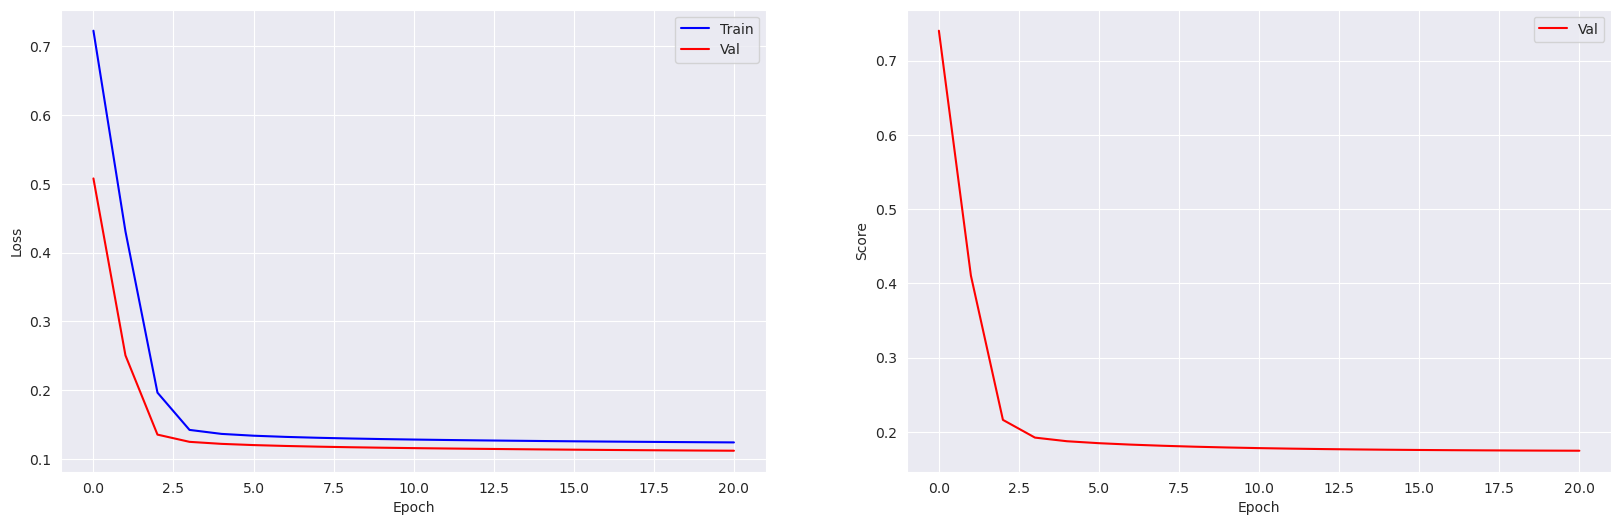

Type: VNNWithDtModel, Test loss: 0.11, Test score: 0.1896


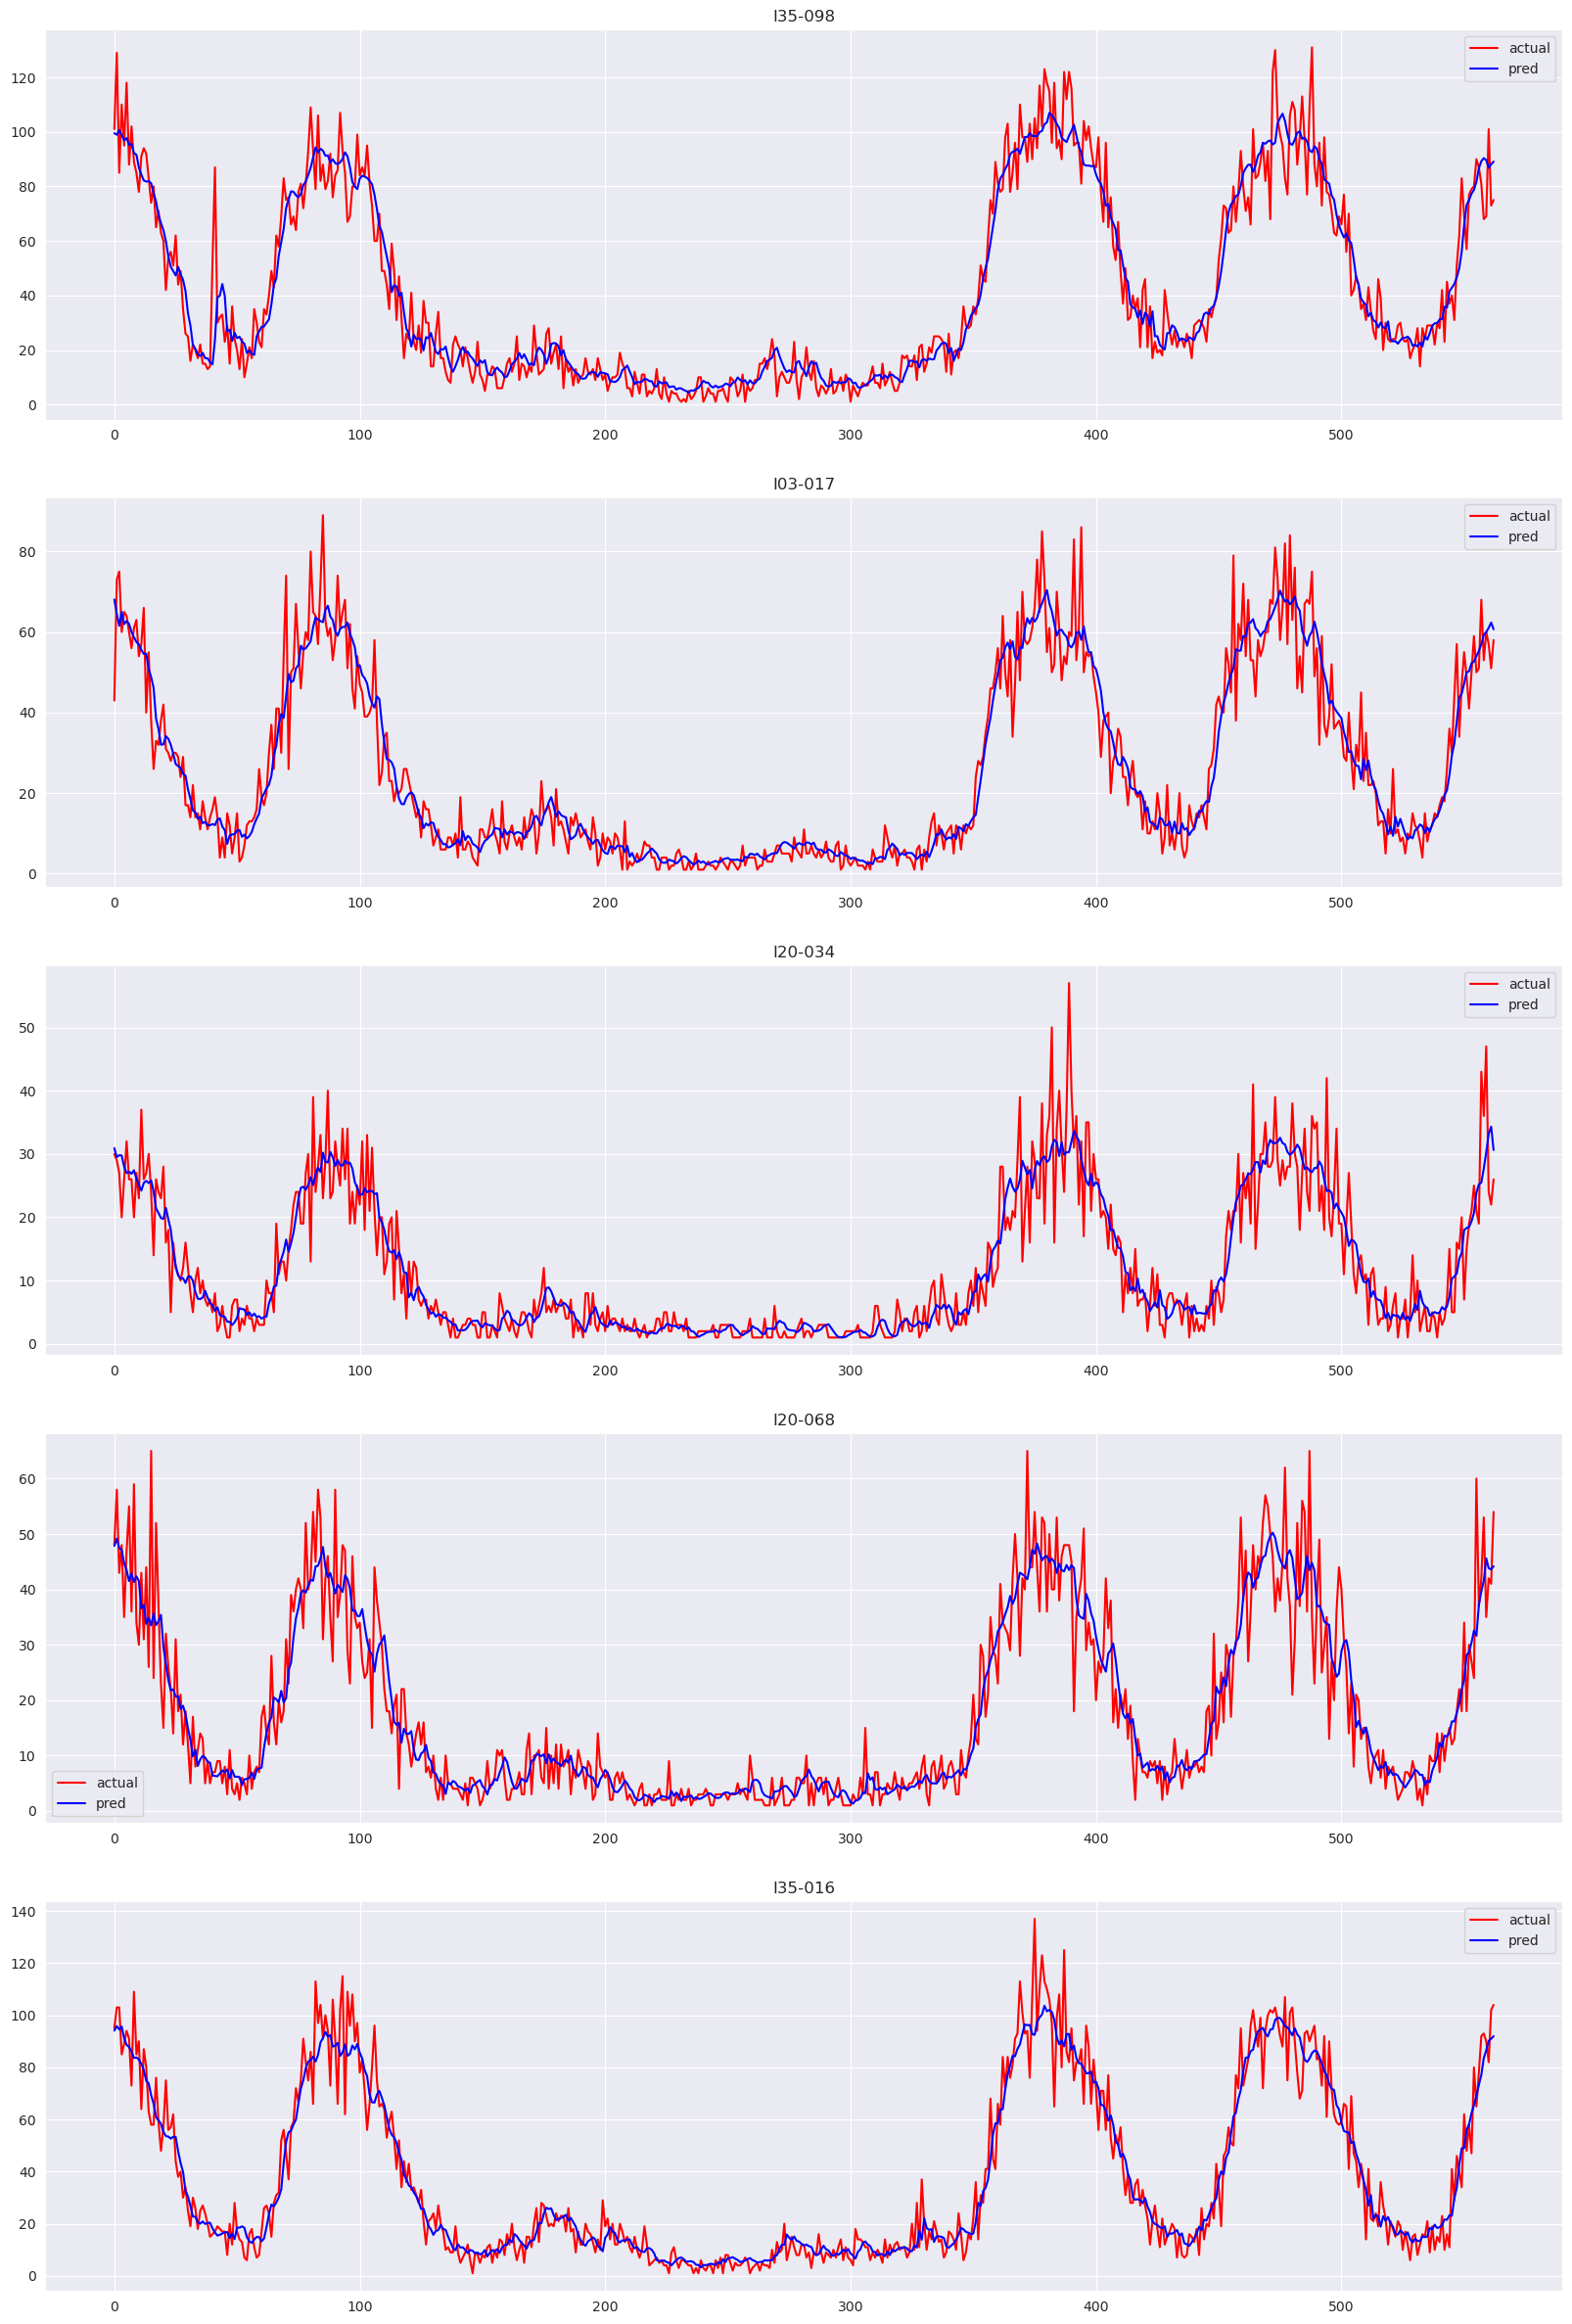

In [79]:
class VNNWithDtModel(nn.Module):
    def __init__(self, seq_len, in_channels=1, dt_dim=4):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.hidden_dim = 64
        self.dt_new_dim = 16

        self.nn = nn.Sequential(
            nn.Linear(self.window * self.in_channels + self.dt_new_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )

        # self.t2v = Time2Vec(dt_dim, 16)
        self.dt_nn = nn.Sequential(
            nn.Linear(dt_dim, 64),
            nn.ReLU(),
            nn.Linear(64, self.dt_new_dim)
        )

    def forward(self, snapshot):
        x = snapshot.y[:-1]
        x = x.transpose(0, 1)
        nodes_num = len(x)

        dt_feats = snapshot.time_feats[-1]

        # X_dt = self.t2v(X_dt)
        dt_feats = self.dt_nn(dt_feats)

        dt_feats = dt_feats.unsqueeze(-1).expand(-1, nodes_num).T

        x = x.reshape(nodes_num, -1)

        input = torch.cat((x, dt_feats), dim=-1)
        return self.nn(input).squeeze(-1)


model = VNNWithDtModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=1e-4, num_epochs=20, plot=True, plot_update_freq=2)
evaluate_plot(model, test_ds)

<h2>VNN + Time Features + Node Embeddings</h2>

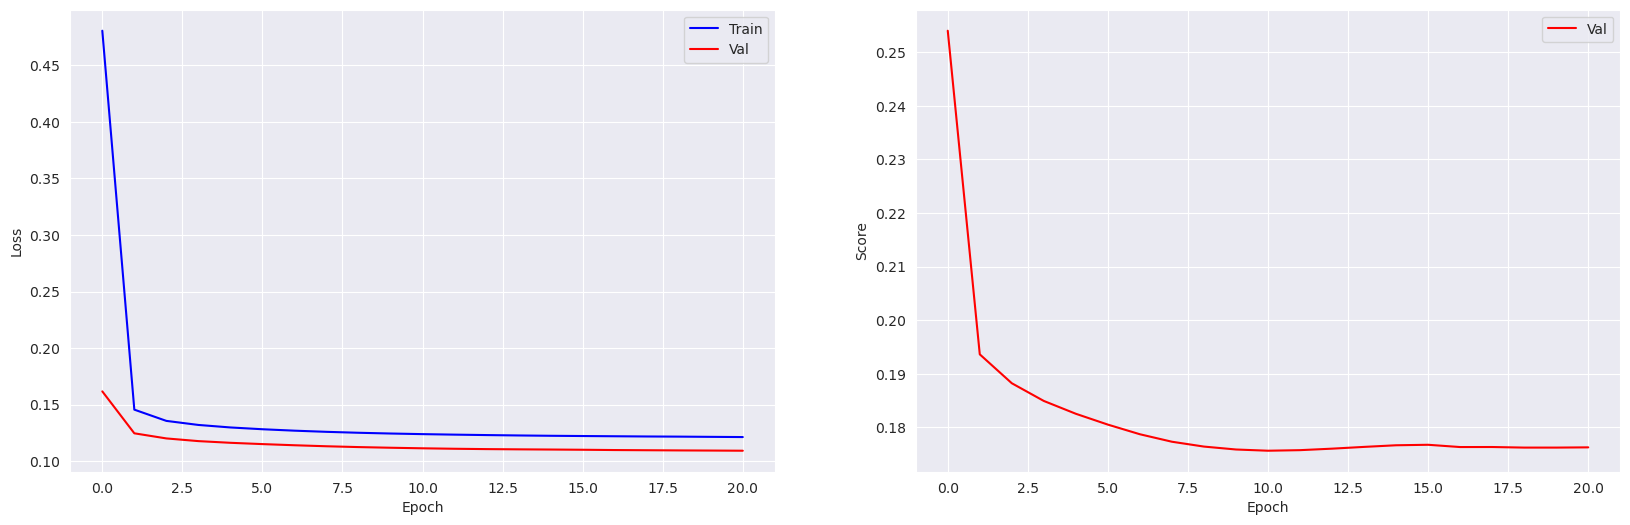

Type: VNN_WithDtEmbModel, Test loss: 0.11, Test score: 0.1898


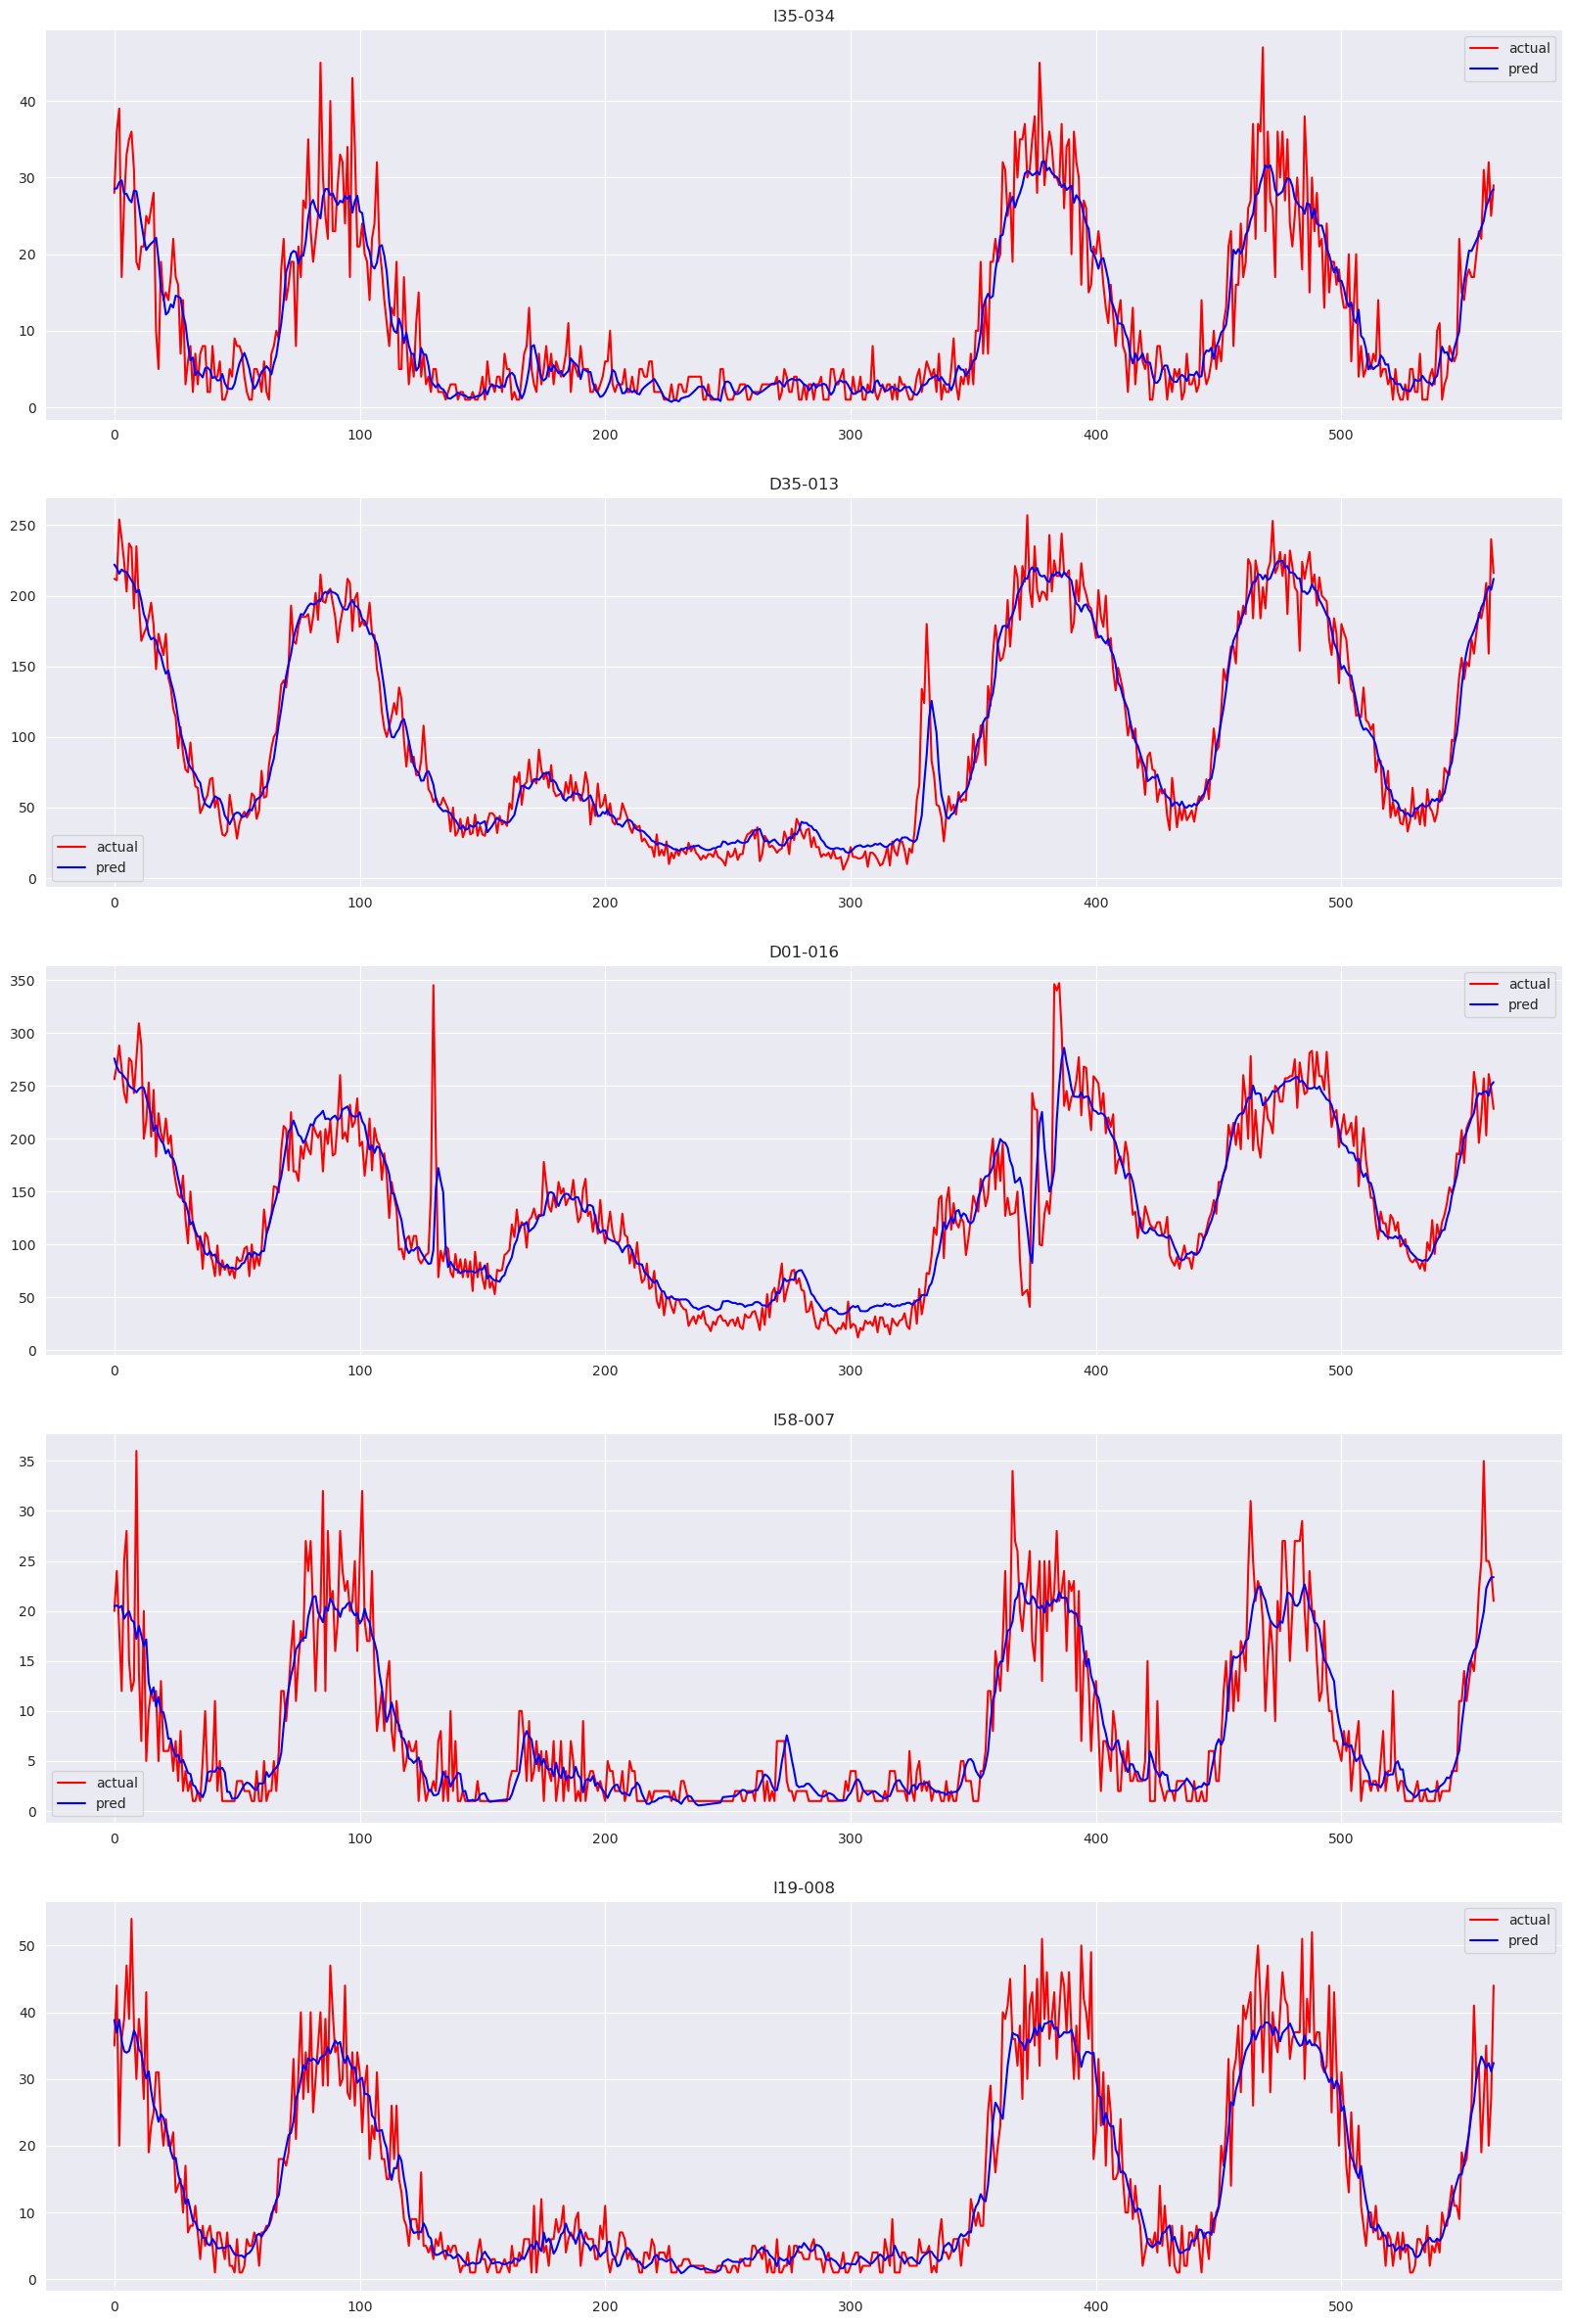

In [82]:
class VNN_WithDtEmbModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, dt_dim=4, emb_dim=32, *args, **kwargs):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.hidden_layer = 64

        self.emb_nn = nn.Sequential(
            nn.Linear(self.emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        self.dt_nn = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.nn = nn.Sequential(
            nn.Linear(32*2 + in_channels * self.window, self.hidden_layer),
            nn.ReLU(),
            nn.Linear(self.hidden_layer, 1))

    def forward(self, snapshot):
        x = snapshot.y[:-1]
        x = x.transpose(0, 1)
        nodes_num = len(x)

        dt_feats = snapshot.time_feats[-1]

        # X_dt = self.t2v(X_dt)
        dt_feats = self.dt_nn(dt_feats)
        emb = self.emb_nn(pyg_data.x)

        dt_feats = dt_feats.unsqueeze(-1).expand(-1, nodes_num).T

        x = x.reshape(nodes_num, -1)

        input = torch.cat((x, dt_feats, emb), dim=-1)
        return self.nn(input).squeeze(-1)

model = VNN_WithDtEmbModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=2e-4, num_epochs=20, plot=True, plot_update_freq=5)
evaluate_plot(model, test_ds)

<h2>Reccurent GNN</h2>

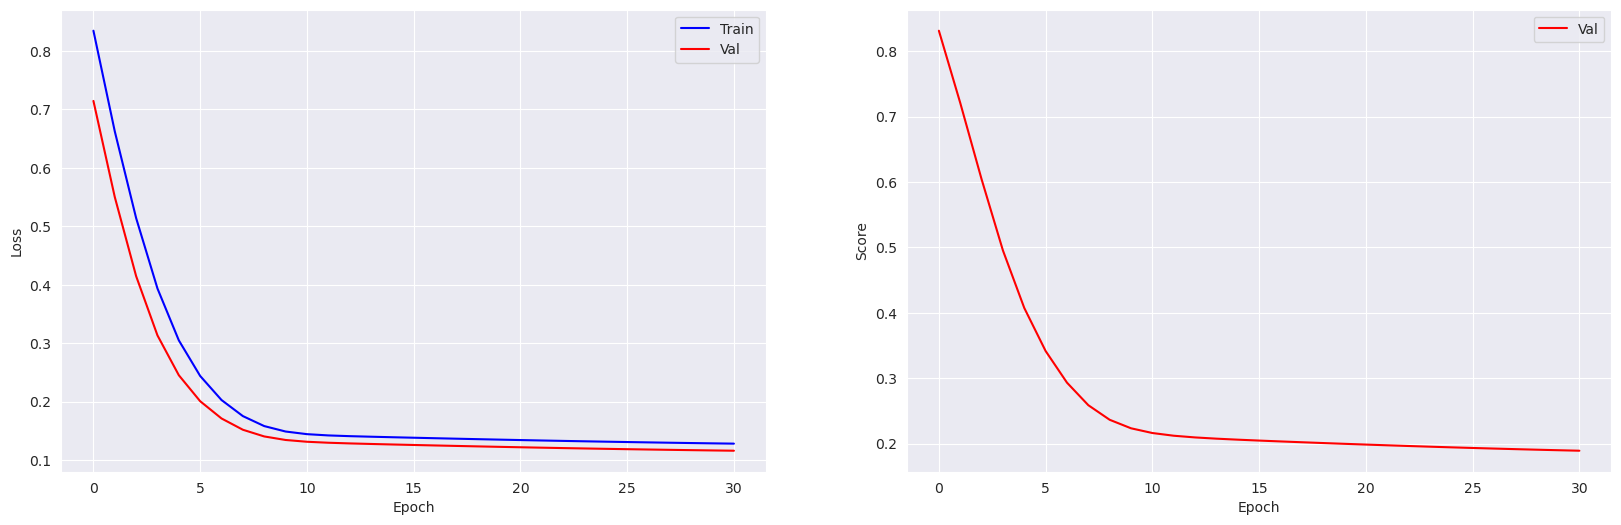

Type: RecurrentGCN, Test loss: 0.11, Test score: 0.1996


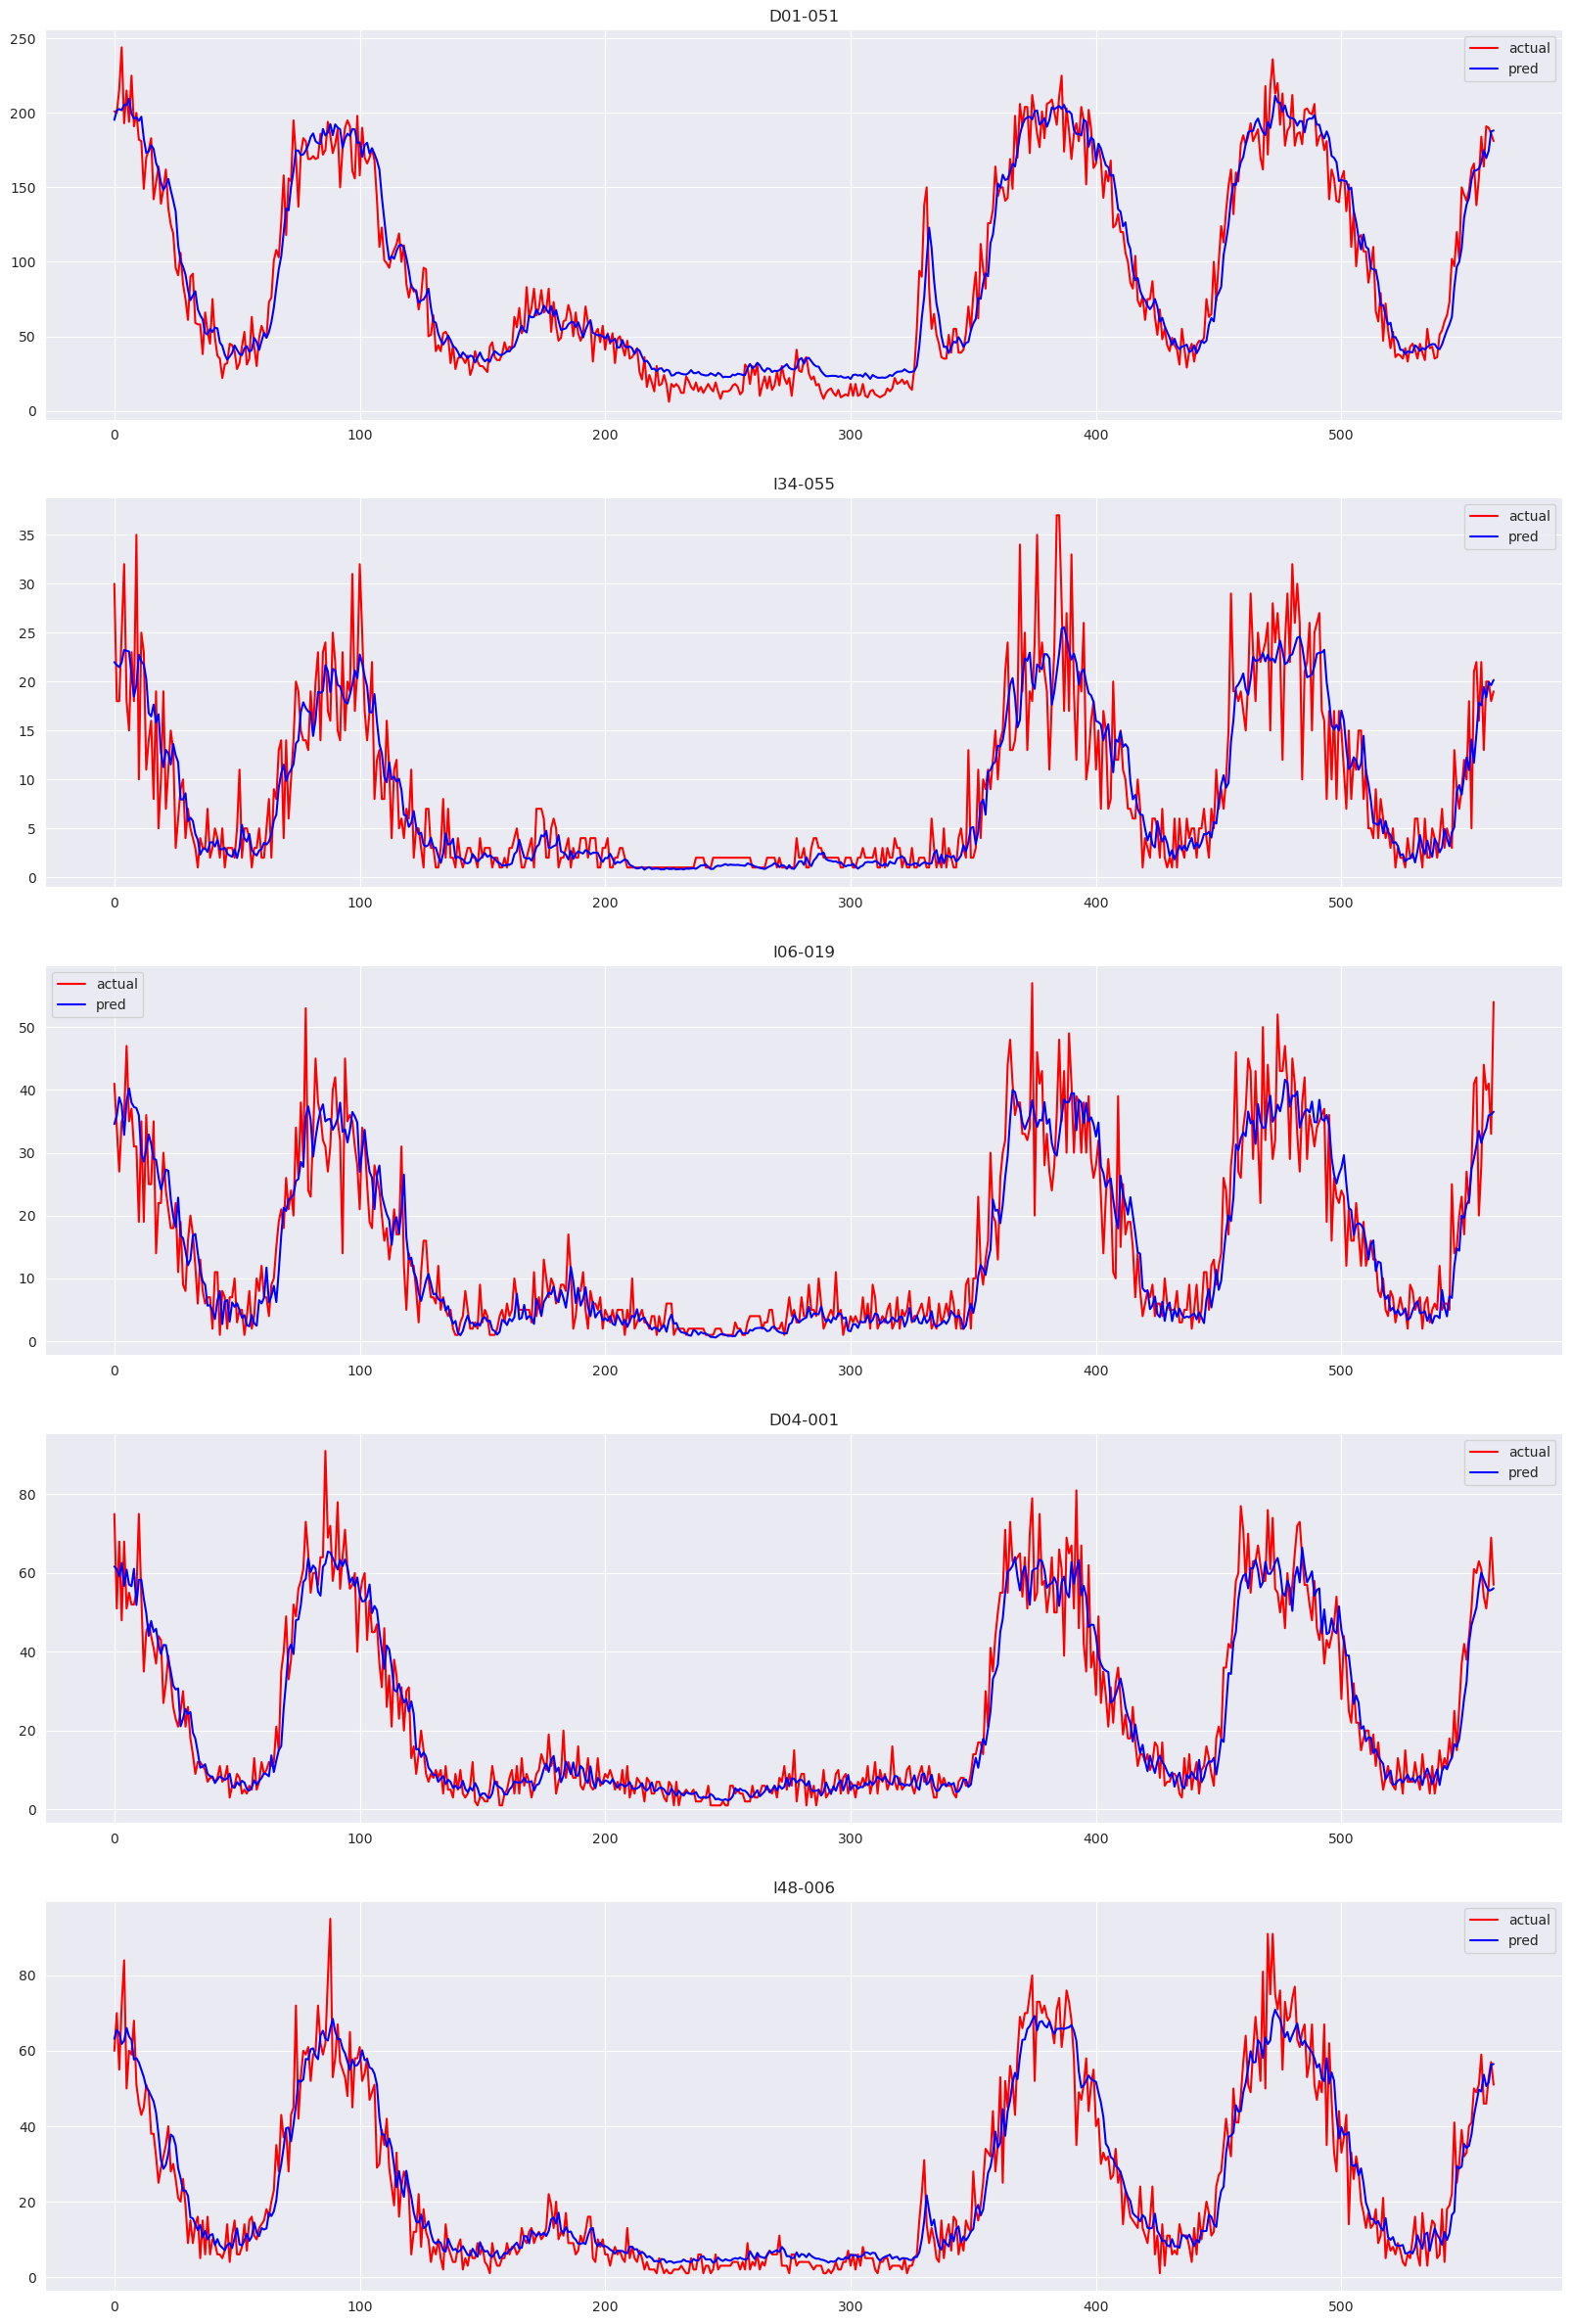

In [83]:
from torch_geometric_temporal.nn.recurrent import GConvGRU
import torch.nn.functional as F

class RecurrentGCN(nn.Module):
    def __init__(self, seq_len, filters=32):
        super().__init__()
        self.recurrent = GConvGRU(seq_len, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, snapshot):
        x = snapshot.y[:-1].T
        edge_index = snapshot.edge_index
        edge_attr = snapshot.edge_attr
        h = self.recurrent(x, edge_index, edge_attr)
        h = F.relu(h)
        h = self.linear(h).squeeze(-1)
        return h

model = RecurrentGCN(seq_len=SEQ_LEN).to(device)
model = run(model, results, lr=1e-4, num_epochs=30, plot=True, plot_update_freq=2)
evaluate_plot(model, test_ds)

In [84]:
import json
with open('results_att.json', mode='w') as f:
    json.dump(results, f, indent=4)

**Attention**

In [27]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim: int, dropout: float = 0.1, max_len: int = 128):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, seq_len: int) -> Tensor:
        """
        Args:
            seq_len: int
        Returns:
            x: Tensor, shape [seq_len, dim]
        """
        x = self.dropout(self.pe[:seq_len])
        return x

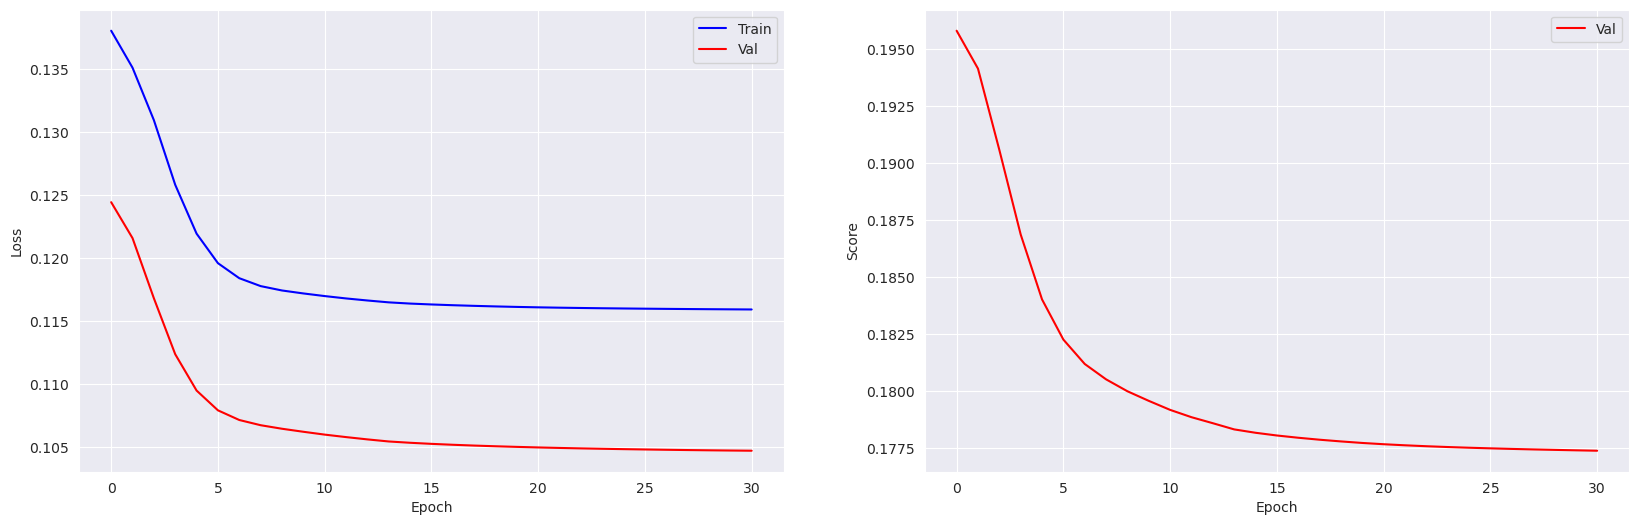

Type: SpatioTemporalAttention, Test loss: 0.10, Test score: 0.1883


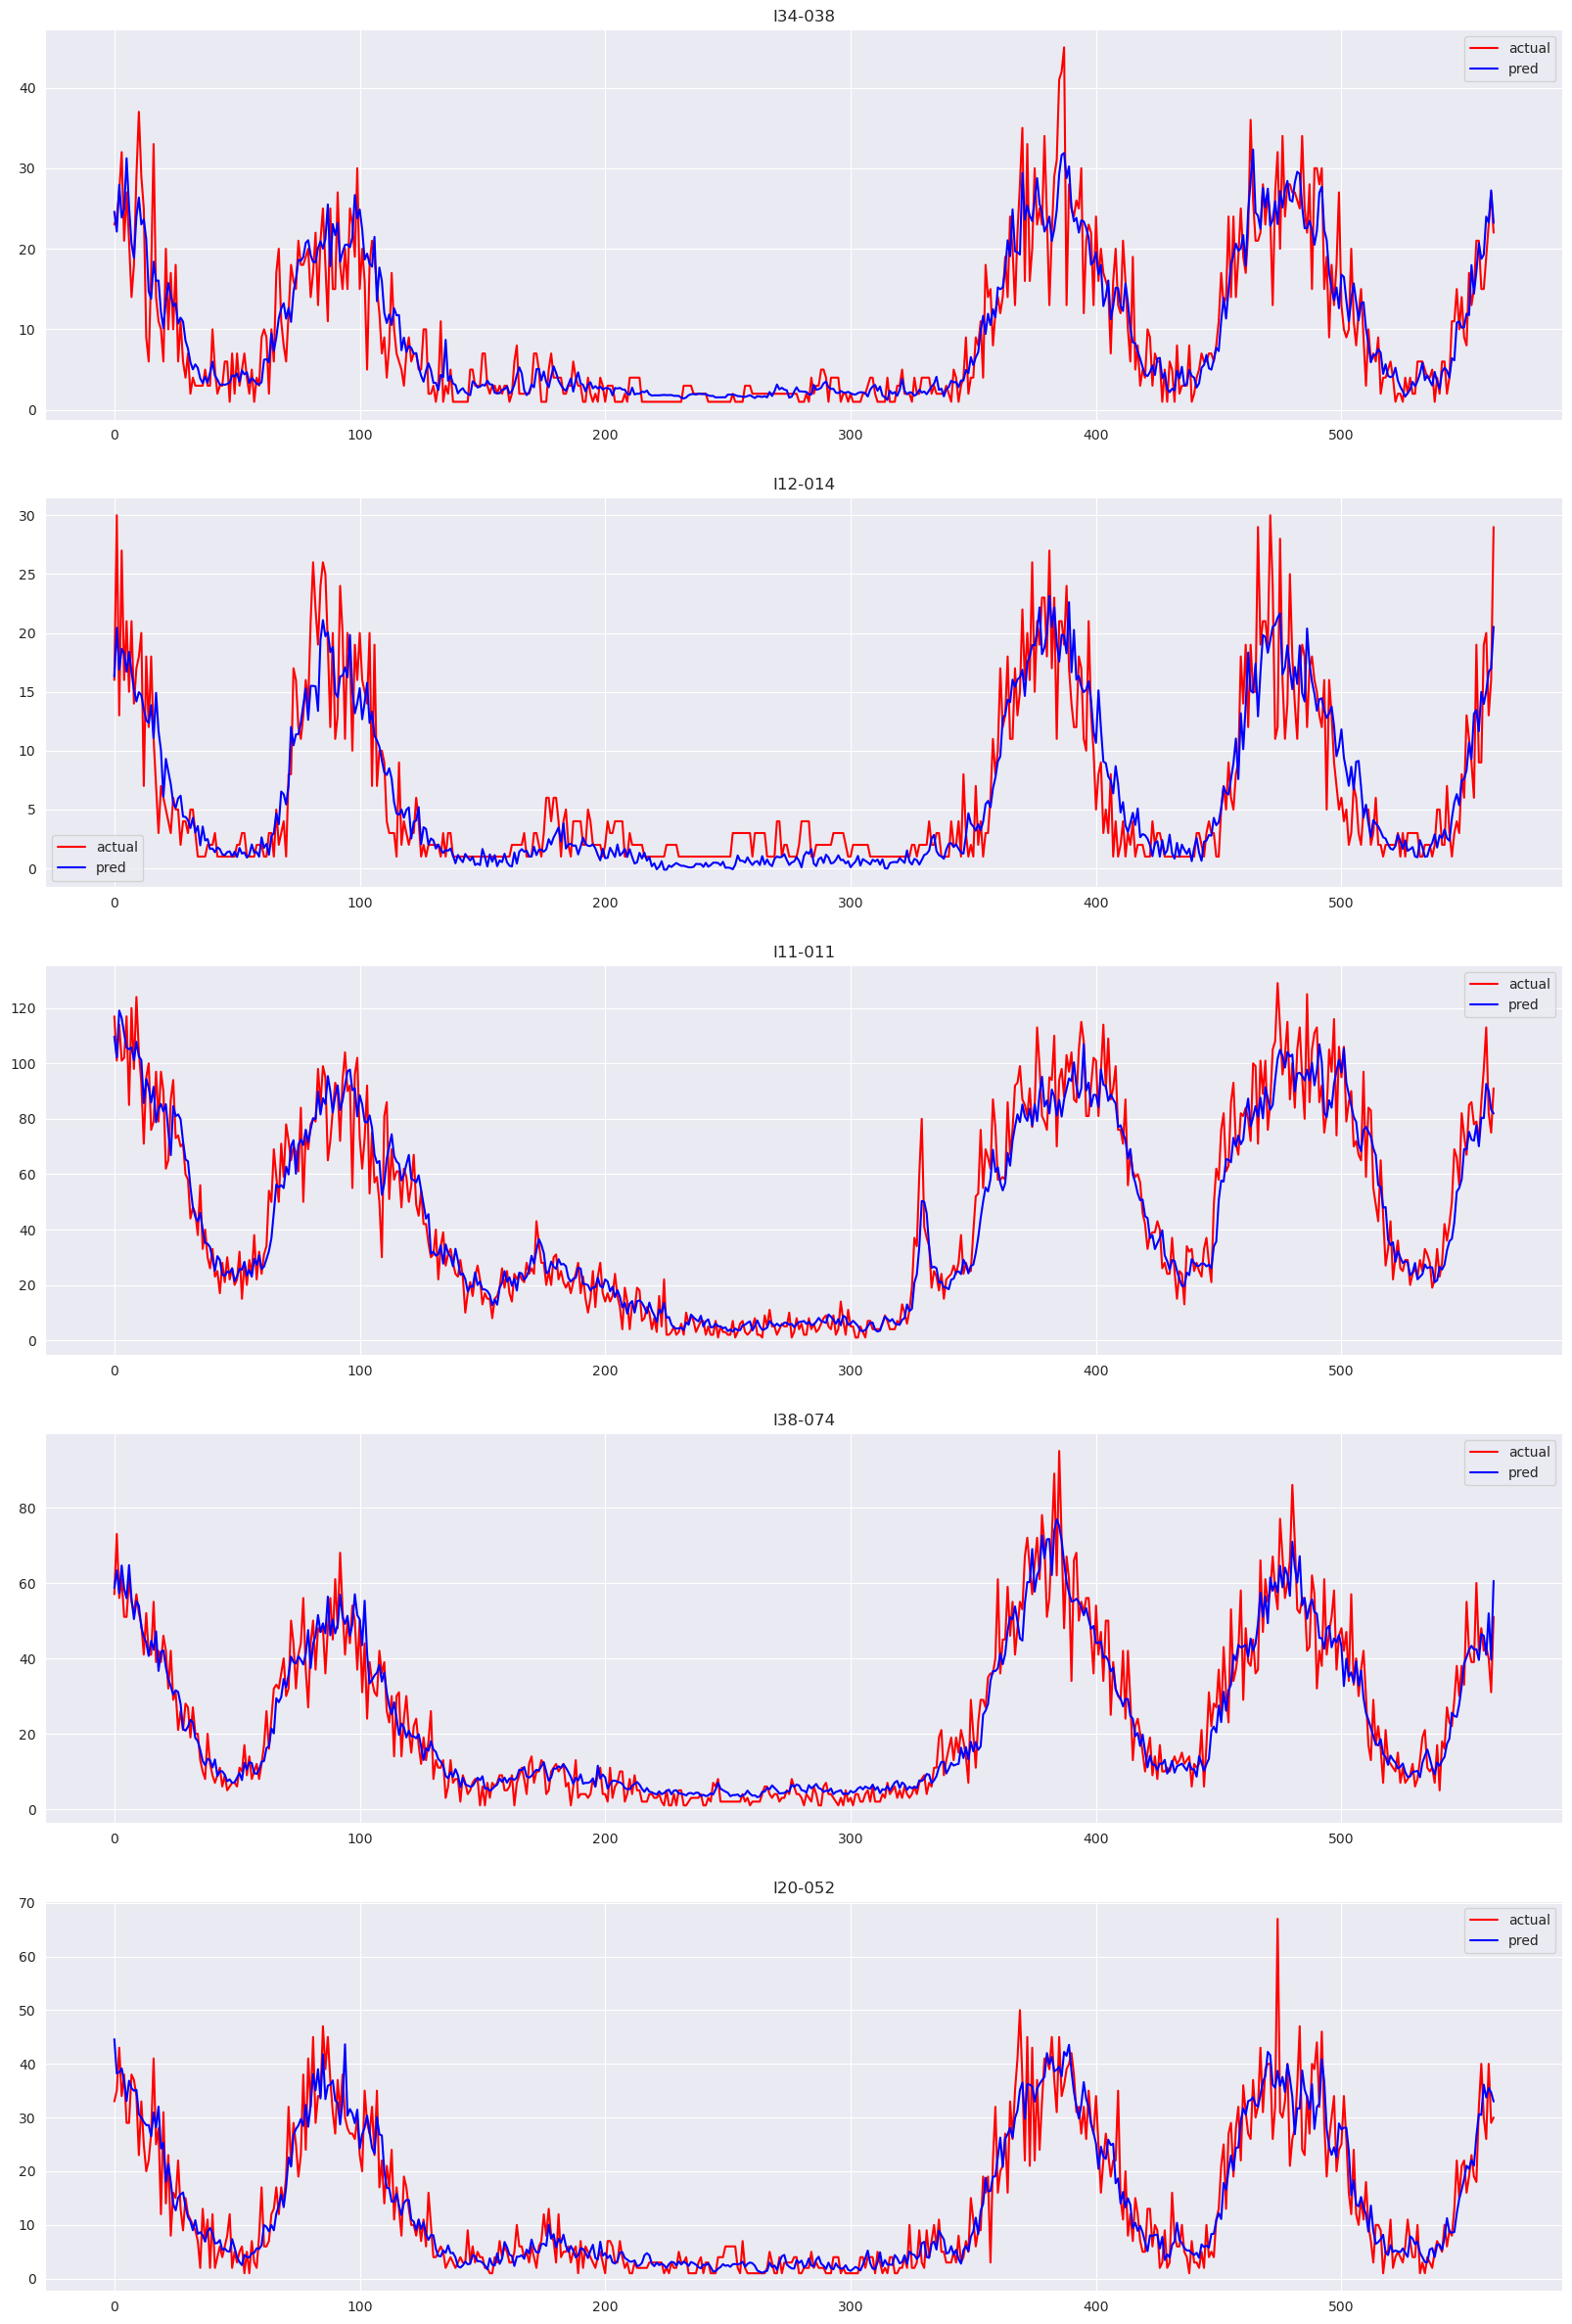

CPU times: user 6min 19s, sys: 567 ms, total: 6min 19s
Wall time: 6min 22s


In [38]:
%%time

class SpatioTemporalModule(pyg.nn.MessagePassing):
    def __init__(self, seq_len, hidden_dim=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.edge_attr_dim = 1
        self.seq_len = seq_len

        self.lin = nn.Parameter(torch.rand(seq_len))
        self.bias = nn.Parameter(torch.rand(1))
        self.k = nn.Parameter(torch.rand(1))

        self.self_nn = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 1))

        self.neighbor_nn = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 1))

        self.ffn = nn.Sequential(
            nn.Linear(5, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1))

    def forward(self, past_targets, past_emb, future_emb, edge_index, edge_attr):
        """Returns estimated targets for query nodes using scaling features and node embeddings.
        This function works utilizing message passing principle. For more information check the following link
        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

        Args:
            past_targets (torch.Tensor), shape [nodes_num, seq_len]: targets from the past lags
            past_emb (torch.Tensor), shape [nodes_num, seq_len, past_emb_dim]: embeddings for the past observations
            future_emb (torch.Tensor), shape [nodes_num, future_emb_dim]: embeddings for the time T + 1
            edge_index (torch.Tensor): edges for the bipartite graph
            edge_attr (torch.Tensor): edge attributes (dist)

        Returns:
            torch.Tensor, shape[nodes, 1]: estimated targets for nodes on T+1
        """

        # print(edge_index[:, :20])
        # print(past_targets.shape, past_emb.shape, future_emb.shape)
 
        seq_len = past_targets.shape[1]
        nodes_num = past_targets.shape[0]
        
        past_emb = past_emb.reshape(-1, past_emb.size(-1))
        past_targets = past_targets.reshape(-1).unsqueeze(-1)
        # idx = torch.eye(seq_len)[None, :].expand(nodes_num, -1, -1).reshape(-1, seq_len).to(device)

        out = self.propagate(edge_index,
            targets=past_targets, past_emb=past_emb, future_emb=future_emb, edge_attr=edge_attr,
            size=(nodes_num * seq_len, nodes_num))

        # print(out.shape)
        # out = torch.cat([out, future_emb], dim=-1)
        # out = self.ffn(out)

        return out.squeeze(-1)

    def message(self, targets_j, past_emb_j, future_emb_i, edge_attr, index):
        # print(targets_j.shape, past_emb_j.shape, future_emb_i.shape, edge_attr.shape)
        # print(mes.shape)
        self_edge_index = edge_attr[:, 0] == 0
        neighbors_edge_index = edge_attr[:, 0] != 0

        self_attr = edge_attr[self_edge_index]
        neighbors_attr = edge_attr[neighbors_edge_index]

        self_emb = past_emb_j[self_edge_index]
        neighbors_emb = past_emb_j[neighbors_edge_index]

        self_targets = targets_j[self_edge_index]
        neighbors_targets = targets_j[neighbors_edge_index]

        self_logits = self.self_nn(self_emb)


        neighbors_mes = torch.cat((neighbors_emb, neighbors_attr), dim=-1)
        neighbors_logits = self.neighbor_nn(neighbors_mes)
        # print(neighbors_logits.shape)
        
        weights = torch.zeros_like(targets_j)
        
        # print(weights.shape, self_logits.shape)
        weights[edge_attr[:, 0] == 0] = self_logits
        weights[edge_attr[:, 0] != 0] = neighbors_logits

        att_weights = pyg.utils.softmax(weights, index)
        # print(att_weights.shape)
        # fuk()
        # att_weights = logits
        # print(att_weights.shape)
        out = att_weights * targets_j

        # out = logits
        return out

    def aggregate(self, inputs, index):
        out = torch_scatter.scatter(inputs, index, dim=0 ,reduce='sum')
        return out


def make_temporal_edge_index(seq_len, nodes_num):
    return torch.vstack([torch.arange(0, nodes_num * seq_len, 1),
        torch.arange(0, nodes_num, 1)[:, None].expand(-1, seq_len).reshape(-1)]).to(device), \
        torch.zeros(nodes_num * seq_len).unsqueeze(-1).to(device)


def make_spatio_temporal_edge_index(seq_len, edge_index, edge_attr, device=device):
    # print(edge_index.shape)
    # E, edge_attr = edge_index, edge_attr
    E, edge_attr = pyg.utils.add_self_loops(edge_index, edge_attr, fill_value=0)
    # print(E.shape)
    # E = edge_index
    # E = torch.vstack([torch.arange(0, 12), torch.arange(0, 12)]).to(device)

    edge_index = torch.vstack([
        torch.cat([torch.arange(s * seq_len, (s + 1) * seq_len) for s in E[0]]).to(device),
        E[1][:, None].expand(-1, seq_len).reshape(-1)])

    edge_attr = edge_attr.expand(-1, seq_len).reshape(-1, 1)
    return edge_index, edge_attr

# e, a = make_temporal_edge_index(SEQ_LEN, len(pyg_data.x))
e, a = make_spatio_temporal_edge_index(SEQ_LEN, pyg_data.edge_index, pyg_data.edge_attr)

class SpatioTemporalAttention(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, dt_dim=4, emb_dim=32):
        super().__init__()
        self.window = seq_len
        self.in_dim = in_channels
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.pos_enc_dim = 8
        self.hidden_layer = 16

        self.emb_nn = nn.Sequential(
            nn.Linear(self.emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.emb_dim)

        )
        self.dt_nn = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.dt_dim)
        )

        self.PE = PositionalEncoding(dim=self.pos_enc_dim)
        self.ST_Module = SpatioTemporalModule(seq_len)

    def positional_encode(self, X):
        """Adds positional encoding to embeddings

        Args:
            X (Tensor), shape [batch_size, nodes_num, seq_len, emb_dim]
        Returns:
            out (Tensor), shape [batch_size, nodes_num, seq_len, emb_dim + pe_dim]
        """
        batch_size, nodes_num, seq_len, emb_dim = X.shape
        pe = torch.fliplr(self.PE(seq_len))[None, :].expand(batch_size * nodes_num, -1, -1)
        X = X.reshape(-1, seq_len, emb_dim)
        out = torch.cat([X, pe], dim=-1).reshape(batch_size, nodes_num, seq_len, emb_dim + self.pos_enc_dim)
        return out

    def compose_future_emb(self, dt_feats, nodes_num):
        # X_future = torch.cat((X_tp1, node_embeds), dim=-1)
        X_future = dt_feats.unsqueeze(-1).expand(-1, nodes_num).T
        return X_future
    
    def compose_past_emb(self, avg_speed):
        nodes_num = len(avg_speed)
        E = torch.eye(self.window, device=device)

        res = torch.cat(
            (avg_speed.unsqueeze(-1),
             E.unsqueeze(-1).expand(-1, -1, nodes_num).permute(2, 0, 1)
             # dt_feats.unsqueeze(-1).expand(-1, -1, nodes_num).permute(2, 0, 1)
             # emb.unsqueeze(-1).expand(-1, -1, -1, self.window).permute(0, 1, 3, 2)
             ), dim=-1)
        # out = self.positional_encode(X_past)
        # print(out.shape)
        return res

    def forward(self, snapshot):
        x = snapshot.y[:-1]
        x = x.transpose(0, 1)
        nodes_num = len(x)

        avg_speed = snapshot.avg_speed[:-1].T

        dt_feats = snapshot.time_feats
        emb = pyg_data.x

        # transforming embeddings
        # X_dt = self.t2v(X_dt)
        dt_feats = self.dt_nn(dt_feats)
        # emb = self.emb_nn(emb)


        past_emb = self.compose_past_emb(avg_speed)
        future_emb = self.compose_future_emb(dt_feats[-1], nodes_num)

        # print(past_emb.shape, future_emb.shape)

        # print(edge_index[:, :20])
        # print(edge_attr[:20])
        # print(edge_index.shape, edge_attr.shape)
        out = self.ST_Module(x, past_emb, future_emb, e, a)

        out = out.squeeze(-1)
        return out

model = SpatioTemporalAttention(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=2e-4, num_epochs=30, plot=True, plot_update_freq=1)
evaluate_plot(model, test_ds)